## Exploratory Data Analysis with Well Log Data

Once data has been collated and sorted through, the next step in the Data Science process is to carry out Exploratory Data Analysis (EDA). This step allows us to identify patterns within the data, understand relationships between the features (well logs) and identify possible outliers that may exist within the dataset. In this stage, we gain an understanding about the data and check whether further processing is required or if cleaning is necessary.

As petrophysicists/geoscientists we commonly use log plots, histograms and crossplots (scatter plots) to analyse and explore well log data. Python provides a great toolset for visualising the data from different perspectives in a quick and easy way.

Exploratory Data Analysis (EDA) is an integral part of Data Science. The same is true for the petrophysical domain and can often be referred to as the Log QC or data review stage of a project. It is at this stage that we begin to go through the data in detail and identify what data we really have, where we have it and what is the quality of the gathered data.

A significant portion of the time that we spend (in some cases up to 90%! - Kohlleffel, 2015) working with well log data is spent trying to understand it and wrangle it into a state that is fit for interpretation. The remaining 10% is when we can get down to the business of carrying out the petrophysical interpretation. This can vary depending on the initial state of the project being worked on.

At the QC stage, we often we find ourselves with multiple input files, random curve names, missing data and extra curves that have no immediate use. This can lead to confusion and frustration, especially when working with multiple tools and vintage datasets. In cases where we have missing data, we need to identify it and determine the best way to handle it. This can be difficult to do by looking at single LAS files in a text editor, but it can be made easier using software. One such method is by using Python, a common and popular programming language.


## Loading the data and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import math
import missingno as msno

In [2]:
wells = pd.read_csv("Desktop/REX LOGS/REX_WELL.csv", header=0)

In [3]:
wells.head()

,CAL,DEPTH,GR,LL9S,LLD,NPHI,POR,RHOB,SONIC,WELL
0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AKASO-001
1,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AKASO-001
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AKASO-001
3,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AKASO-001
4,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AKASO-001


In [4]:
wells.describe()

,CAL,DEPTH,GR,LL9S,LLD,NPHI,POR,RHOB,SONIC
count,116484.000000,201795.000000,148383.000000,52023.000000,124924.000000,127669.000000,12960.000000,136747.000000,92613.000000
mean,12.496004,6628.119490,61.531052,8.181403,24.834176,1.108061,0.288396,39.313265,103.935216
std,2.317655,3440.812898,27.303142,28.361775,183.352624,5.277806,0.062935,118.194946,13.876935
min,-1.860800,0.000000,-14.785700,0.075600,0.064900,-4.026700,0.033100,0.255100,-9.000000
25%,12.000000,4014.500000,36.510100,1.415150,1.590300,0.242000,0.260500,2.132500,95.250000
50%,12.236400,6728.500000,54.698900,2.510300,2.612800,0.293900,0.295000,2.197100,104.047600
75%,13.164100,9251.000000,88.330100,8.058100,13.715725,0.373200,0.319900,2.319300,111.500000
max,24.298600,15000.000000,304.205900,1935.597000,26536.019500,52.006200,0.734800,416.000000,210.500000


In [5]:
wells['WELL'].nunique

<bound method IndexOpsMixin.nunique of 0             AKASO-001
1             AKASO-001
2             AKASO-001
3             AKASO-001
4             AKASO-001
              ...      
201790    AKASO-012-ST1
201791    AKASO-012-ST1
201792    AKASO-012-ST1
201793    AKASO-012-ST1
201794    AKASO-012-ST1
Name: WELL, Length: 201795, dtype: object>

In [6]:
wells['WELL'].unique()

array(['AKASO-001', 'AKASO-013', 'AKASO-002', 'AKASO-003', 'AKASO-004',
       'AKASO-007', 'AKASO-008', 'AKASO-009', 'AKASO-010',
       'AKASO-012-ST1'], dtype=object)

## Identifying Gaps
The data is presented as is and includes a large amount of missing values. Missing data within well logging can arise for a number of reasons including:

Tool failures & problems
Missing by choice (i.e. tools not run due to budgetary constraints)
Human error
Vintage datasets
Issues arising from the borehole environment

## missingno Library
There are a number of ways that we can use to identify where we have data and where we don't.  The first method we will look at is using the missingno library, which provides a nice little toolbox, created by Aleksy Bilgour, as a way to visualise and understand data completeness. More details on the library can be found at https://github.com/ResidentMario/missingno. If you don't have this library, you can quickly install it using pip install missingno into your terminal. The missingno toolbox contains a number of different visualisations, but for this article we will focus on the matrix plot. This can be called by:


<Axes: >

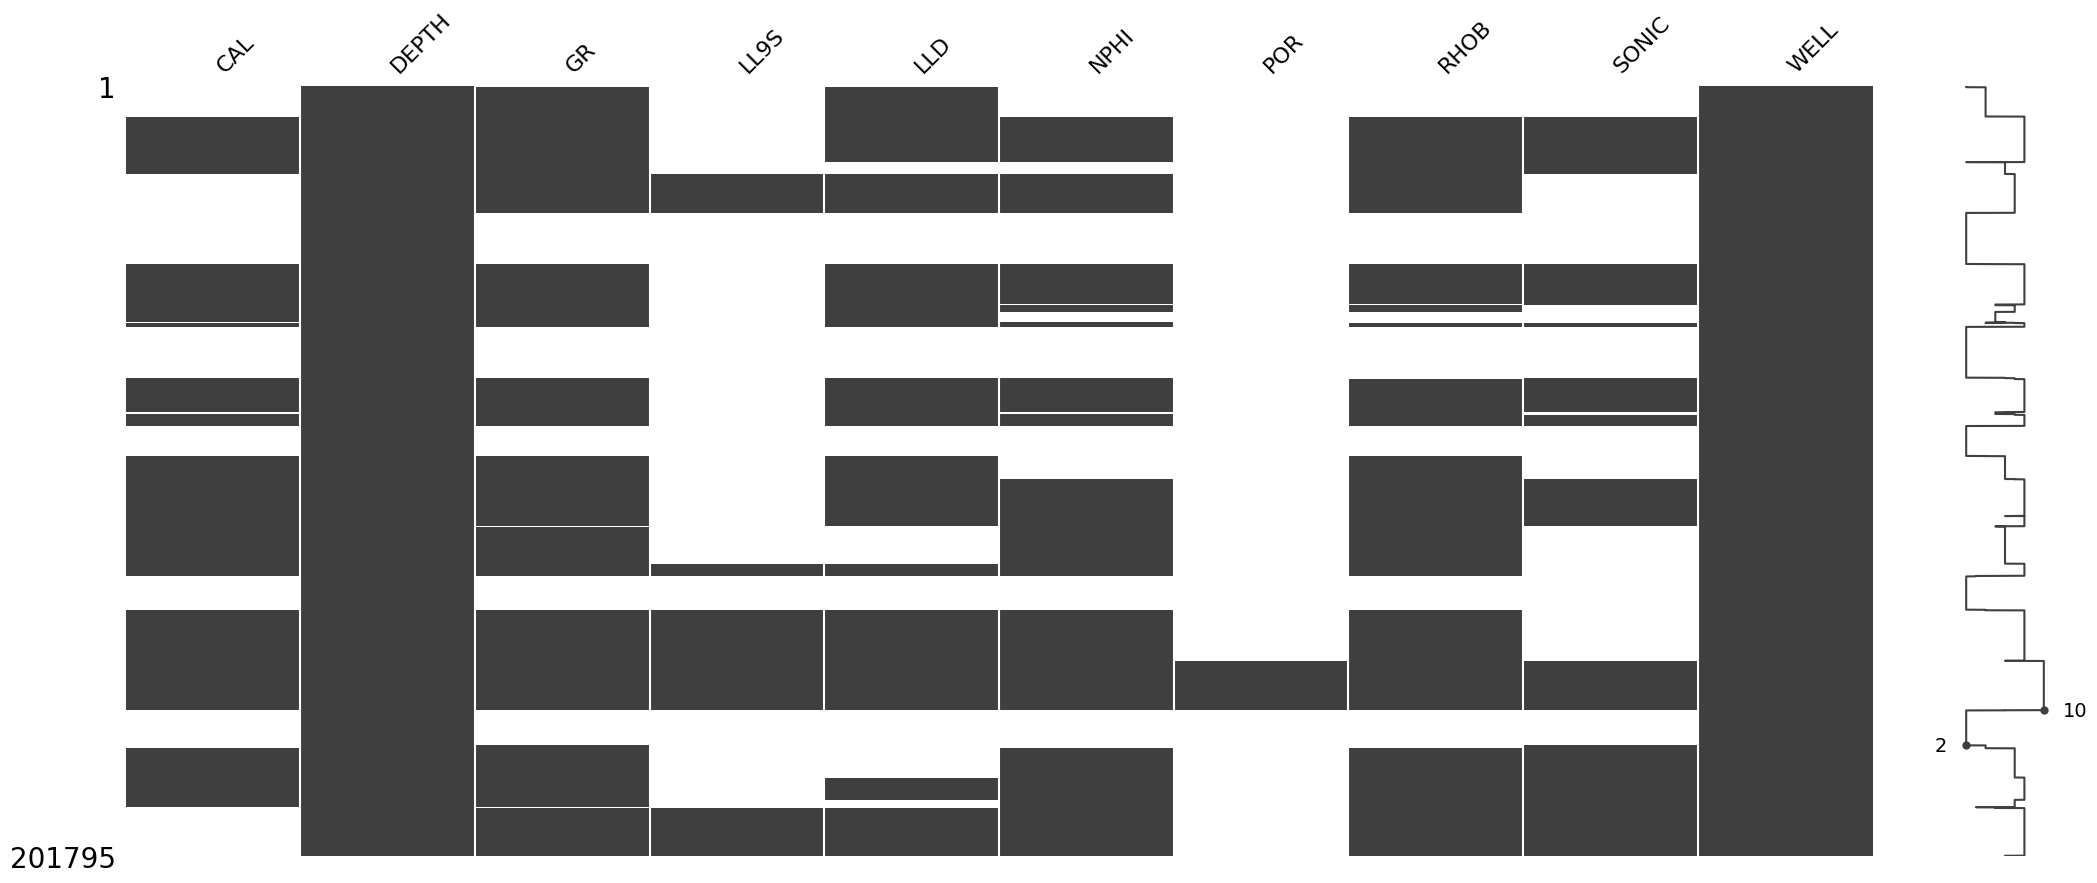

In [7]:
msno.matrix(wells)

This shows us the data density across all of the features (log curves). Over on the right hand side of the figure we have sparkline, which illustrates where we have maximum or minimum nullity in the data. From the visualisation we can can see that only a handful of columns are complete WELL and DEPTH

Others have near full data values such GR, CALI, and RHOB, whereas some have very poor data coverage such as POR and LL9S.

We can also call upon sno.bar(data) to generate a bar chart showing the amount of non-null data values within each column (log curve). Along the top of the chart, we get a total count of the non-null data values.

<Axes: >

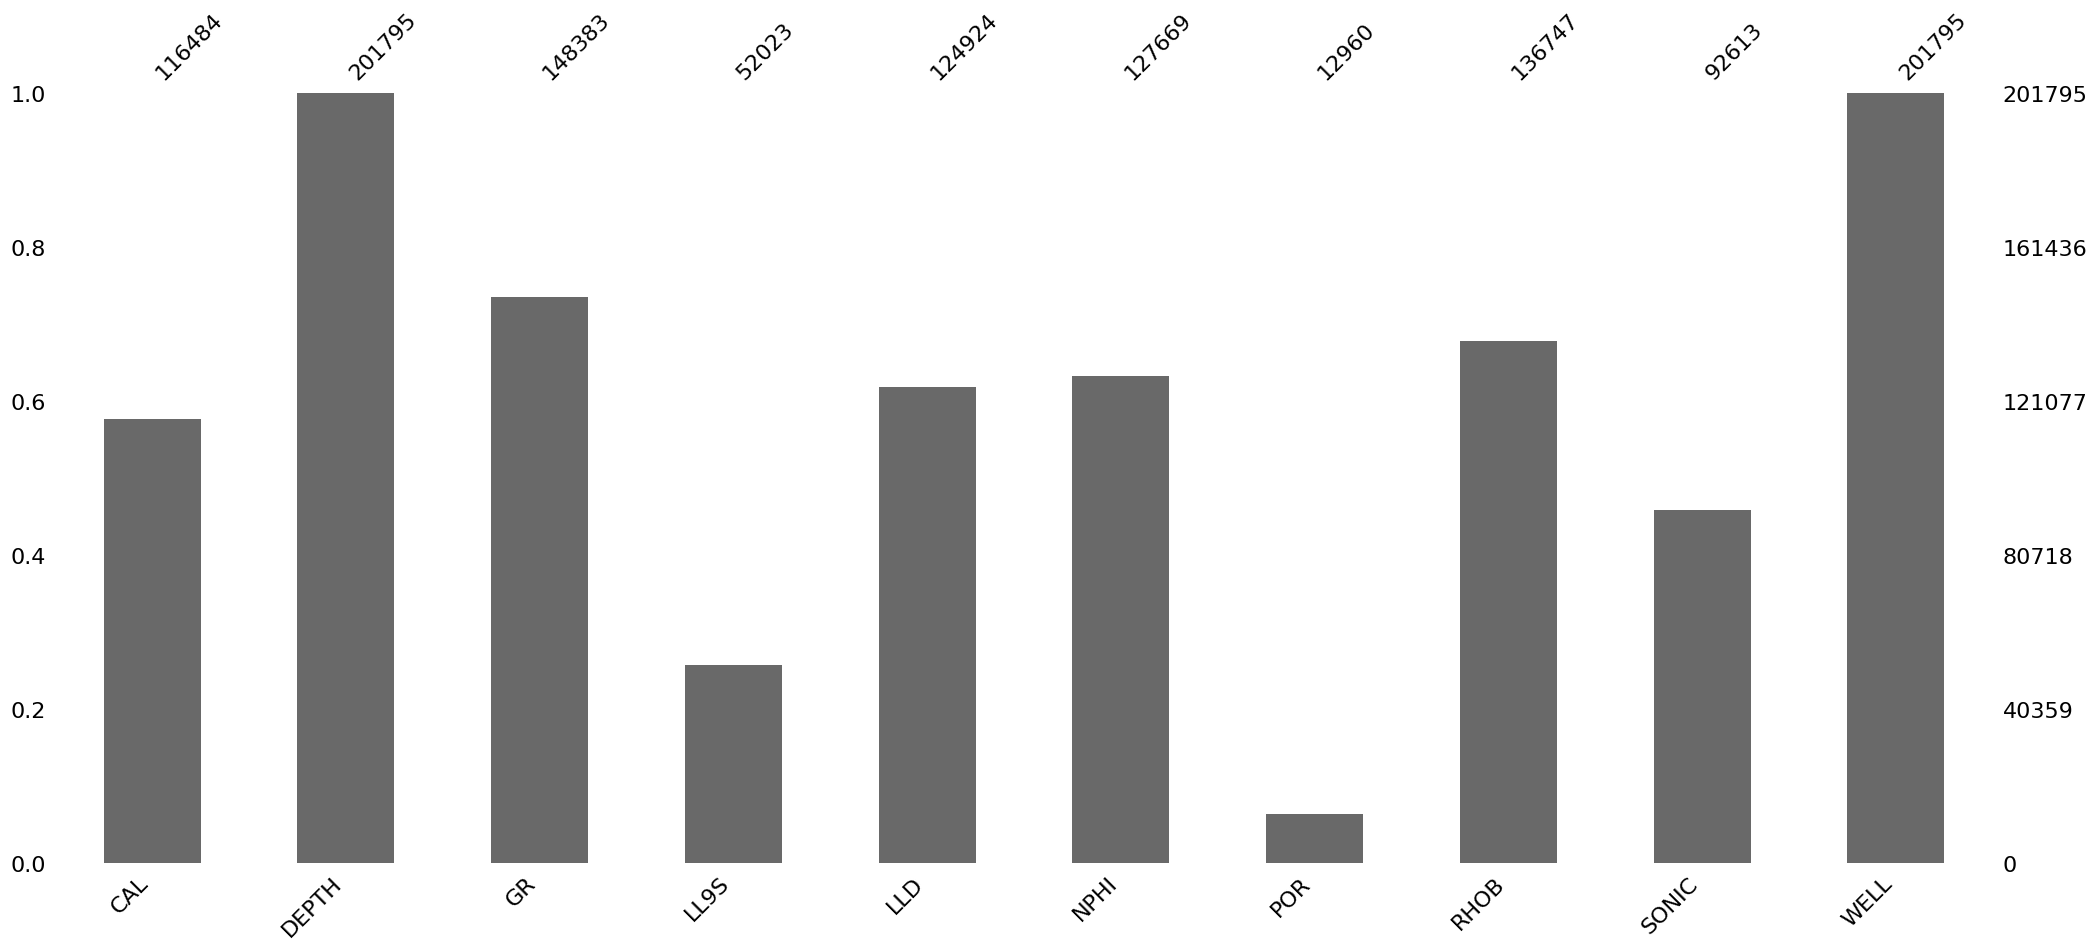

In [8]:
msno.bar(wells)

## Missing Data Visualisation Using Matplotlib

We can further visualise where we have missing data by using matplotlib and the function. If we wanted to generate a plot for all of the curves per well we could save each one out as a file or present the data in a single column. In this example I have only selected common curves that a petrophysicist may use in an interpretation.


In [9]:
# In order for our plot to work as intended, we need to modify the column order of our dataset. 
# This can be achieved by first creating a list of the columns in the order that we want
# or remove a column
plot_cols = ['WELL', 'DEPTH', 'CAL', 'GR', 'LLD', 'RHOB', 'NPHI', 'SONIC']

In [10]:
wells_2 = wells[plot_cols]

In [11]:
wells_2.head()

,WELL,DEPTH,CAL,GR,LLD,RHOB,NPHI,SONIC
0,AKASO-001,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,AKASO-001,0.5,NaN,NaN,NaN,NaN,NaN,NaN
2,AKASO-001,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,AKASO-001,1.5,NaN,NaN,NaN,NaN,NaN,NaN
4,AKASO-001,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
wells_2.describe()

,DEPTH,CAL,GR,LLD,RHOB,NPHI,SONIC
count,201795.000000,116484.000000,148383.000000,124924.000000,136747.000000,127669.000000,92613.000000
mean,6628.119490,12.496004,61.531052,24.834176,39.313265,1.108061,103.935216
std,3440.812898,2.317655,27.303142,183.352624,118.194946,5.277806,13.876935
min,0.000000,-1.860800,-14.785700,0.064900,0.255100,-4.026700,-9.000000
25%,4014.500000,12.000000,36.510100,1.590300,2.132500,0.242000,95.250000
50%,6728.500000,12.236400,54.698900,2.612800,2.197100,0.293900,104.047600
75%,9251.000000,13.164100,88.330100,13.715725,2.319300,0.373200,111.500000
max,15000.000000,24.298600,304.205900,26536.019500,416.000000,52.006200,210.500000


In [13]:
wells_nan = wells_2.copy()

In [14]:
for num, col in enumerate(wells_nan.columns[2:]):
    wells_nan[col] = wells_nan[col].notnull() * (num + 1)
    wells_nan[col].replace(0, num, inplace=True)
    print(col, num) #Print out the col name and number to verify it works
grouped = wells_nan.groupby('WELL')

CAL 0
GR 1
LLD 2
RHOB 3
NPHI 4
SONIC 5


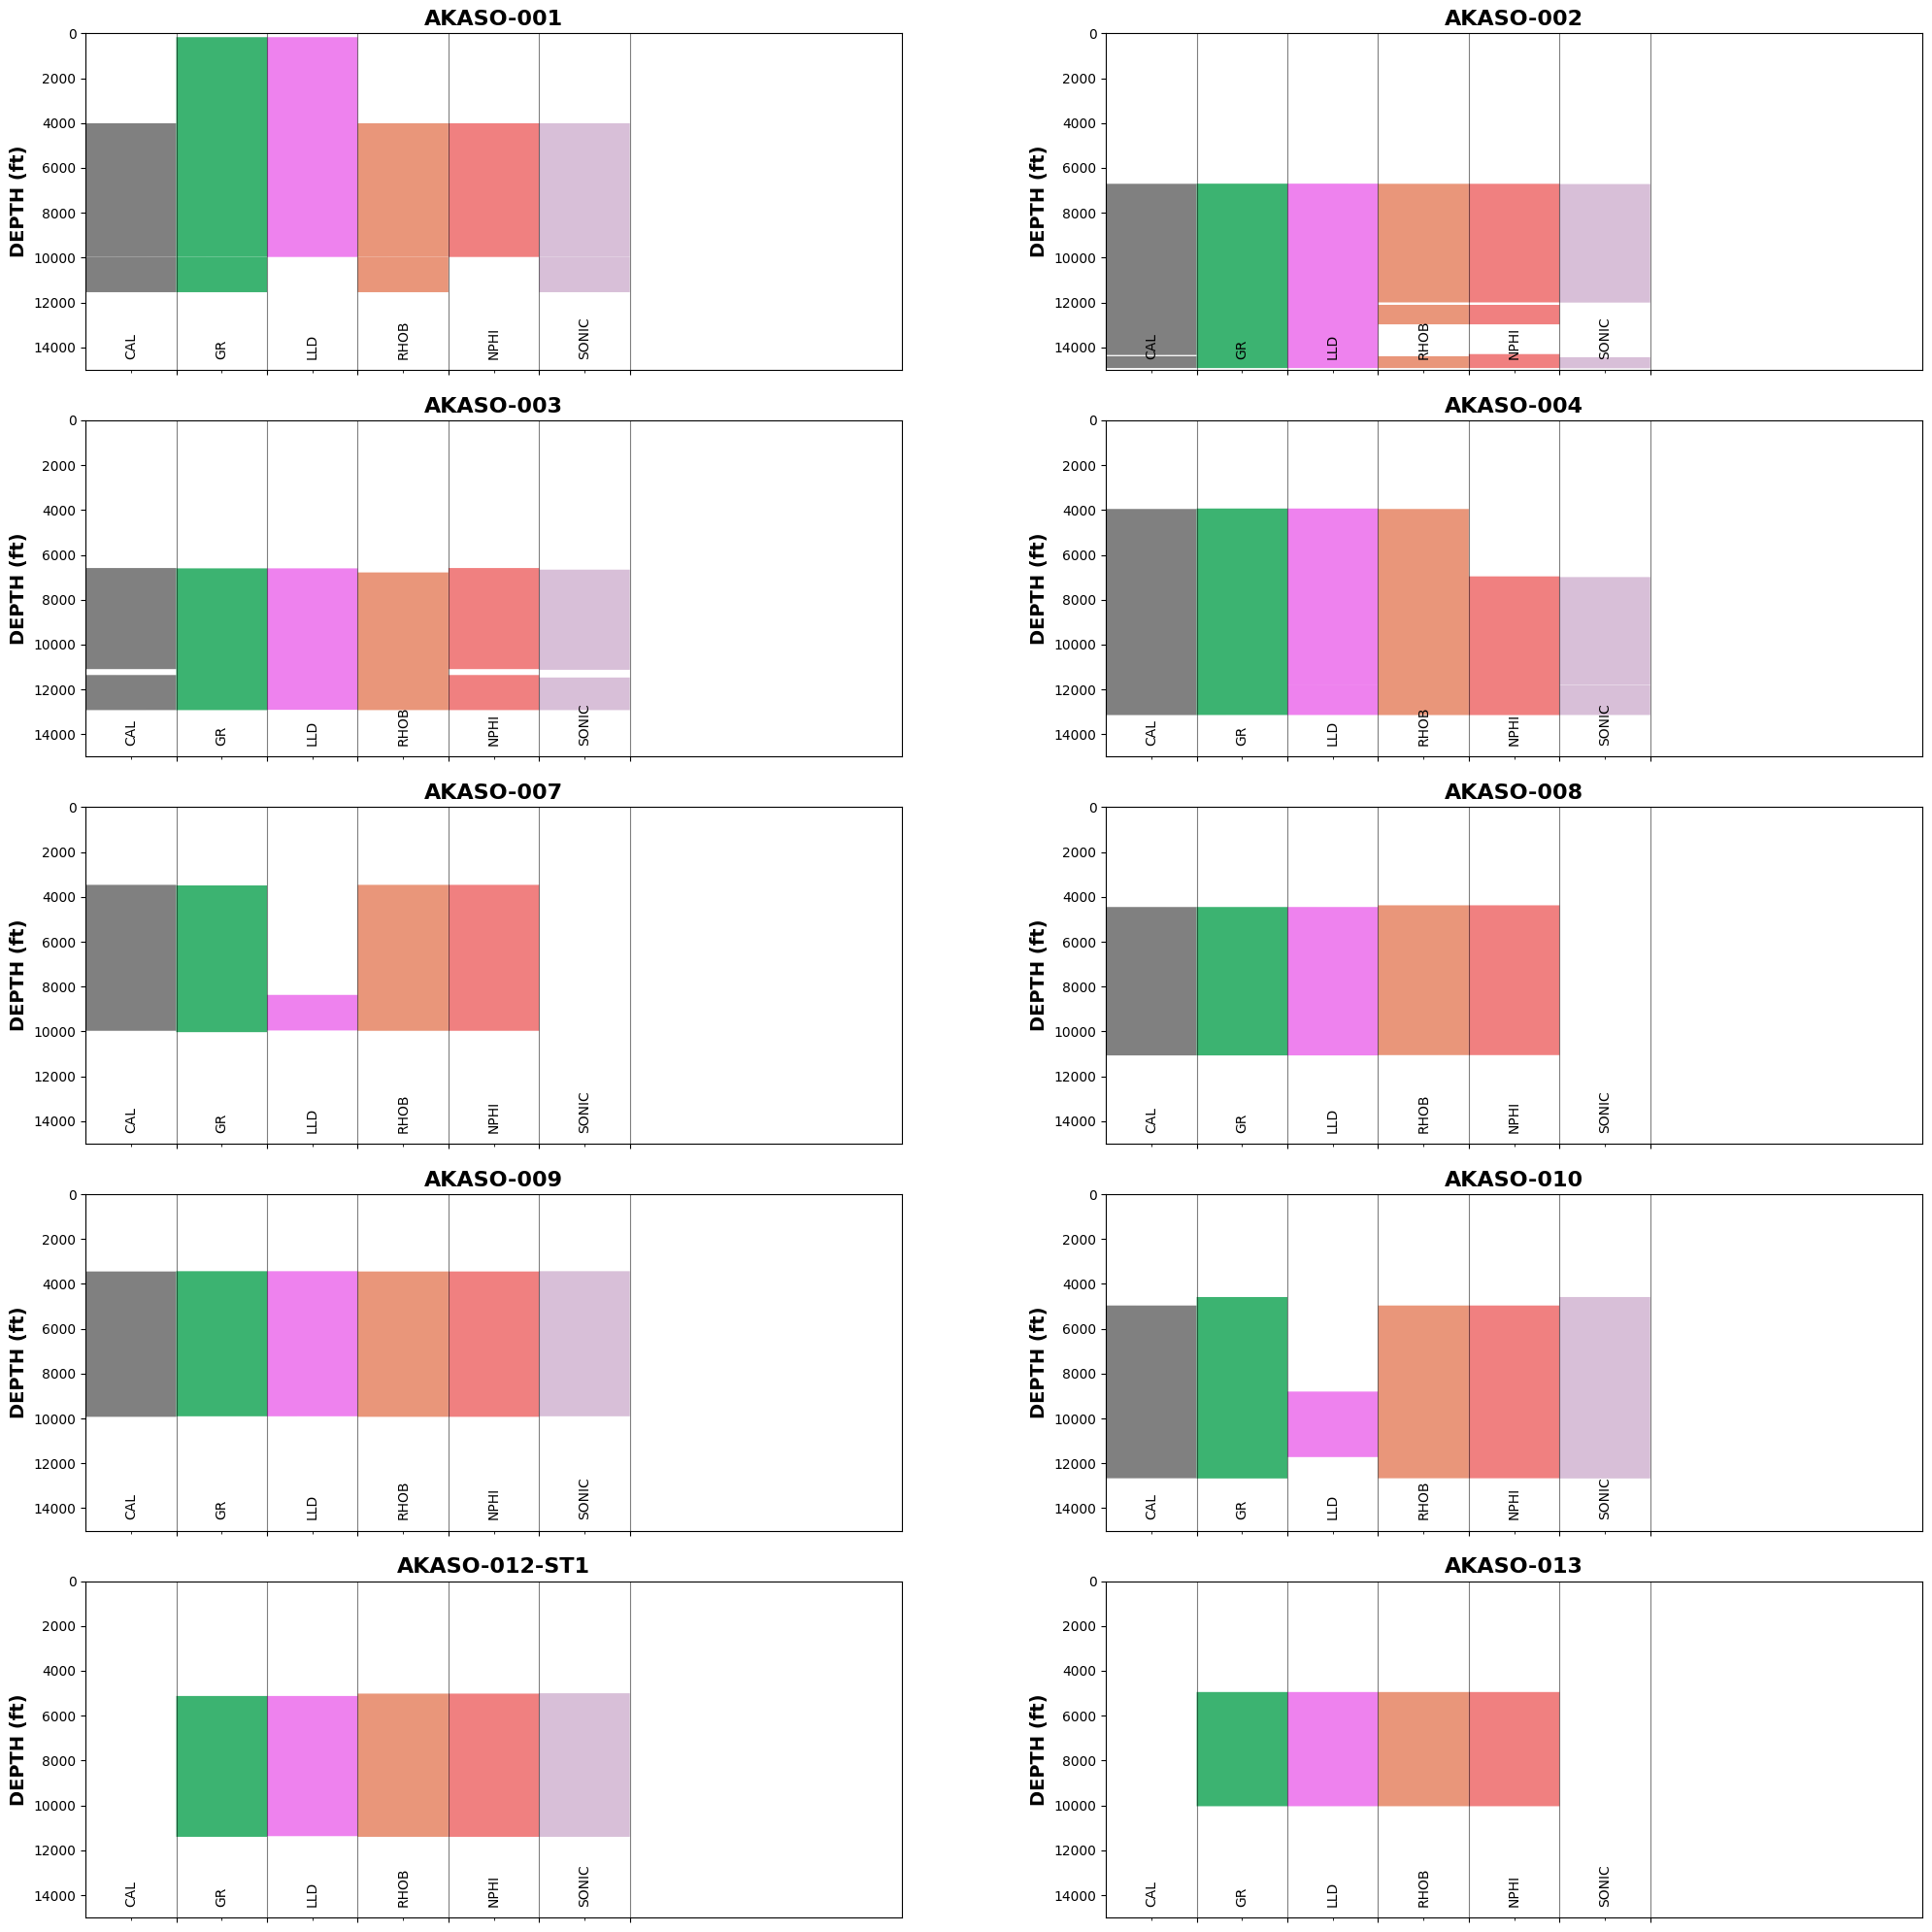

In [15]:
#Setup the labels we want to display on the x-axis
labels = ['CAL', 'GR', 'LLD', 'RHOB', 'NPHI', 'SONIC']

#Setup the figure and the subplots
fig, axs = plt.subplots(5, 2, figsize=(20,20))

#Loop through each well and column in the grouped dataframe
for (name, df), ax in zip(grouped, axs.flat):
    ax.set_xlim(0,9)
    
    #Setup the depth range
    ax.set_ylim(15000, 0)
    
    #Create multiple fill betweens for each curve# This is between
    # the number representing null values and the number representing
    # actual values
    
    ax.fill_betweenx(df.DEPTH, 0, df.CAL, facecolor='grey')
    ax.fill_betweenx(df.DEPTH, 1, df.GR, facecolor='mediumseagreen')
    ax.fill_betweenx(df.DEPTH, 2, df.LLD, facecolor='violet')
    ax.fill_betweenx(df.DEPTH, 3, df.RHOB, facecolor='darksalmon')
    ax.fill_betweenx(df.DEPTH, 4, df.NPHI, facecolor='lightcoral')
    ax.fill_betweenx(df.DEPTH, 5, df.SONIC, facecolor='thistle')
    
    #Setup the grid, axis labels and ticks
    ax.grid(axis='x', alpha=0.5, color='black')
    ax.set_ylabel('DEPTH (ft)', fontsize=14, fontweight='bold')
    
    #Position vertical lines at the boundaries between the bars
    ax.set_xticks([1,2,3,4,5,6], minor=False)
    
    #Position the curve names in the centre of each column
    ax.set_xticks([0.5, 1.5 ,2.5 ,3.5 ,4.5 ,5.5], minor=True)
    
    #Setup the x-axis tick labels
    ax.set_xticklabels(labels,  rotation='vertical', minor=True, verticalalignment='bottom')
    ax.set_xticklabels('', minor=False)
    ax.tick_params(axis='x', which='minor', pad=-10)
    
    #Assign the well name as the title to each subplot
    ax.set_title(name, fontsize=16, fontweight='bold')

plt.savefig('missingdata.png')
plt.tight_layout()
plt.subplots_adjust(hspace=0.15, wspace=0.25)
plt.savefig(fname='missingdata.png', dpi=300)

From the generated image, we can identify where the gaps are in our main curves. From this plot we can determine which wells would be useful to carry forward for machine learning modelling or for further investigation.

In [16]:
wells_3 = wells_2.drop(['CAL', 'SONIC'], axis=1)

In [17]:
wells_3

,WELL,DEPTH,GR,LLD,RHOB,NPHI
0,AKASO-001,0.0,NaN,NaN,NaN,NaN
1,AKASO-001,0.5,NaN,NaN,NaN,NaN
2,AKASO-001,1.0,NaN,NaN,NaN,NaN
3,AKASO-001,1.5,NaN,NaN,NaN,NaN
4,AKASO-001,2.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
201790,AKASO-012-ST1,11398.0,183.8156,NaN,2.0447,0.1761
201791,AKASO-012-ST1,11398.5,183.8156,NaN,2.0447,0.1761
201792,AKASO-012-ST1,11399.0,183.8156,NaN,2.0447,0.1761
201793,AKASO-012-ST1,11399.5,183.8156,NaN,2.0447,0.1761


## Getting Familiar With the Data
In this section we will look at a number of visualisations that can be used to gain insight into our data and how that data relations to lithofacies and geological stratigraphy.

Density - Neutron Distribution by GR and Well
We can further enhance the density neutron data by looking at the WELL distribution across multiple wells.Supplying WELL to the hue parameter. We can then supply the GR column from the dataframe into the col parameter.

The marker can be changed by supplying a value to the marker and size parameters. This will help clean up the plots so we can see more of the data.

Finally, as we are using a hue, we can automatically gene

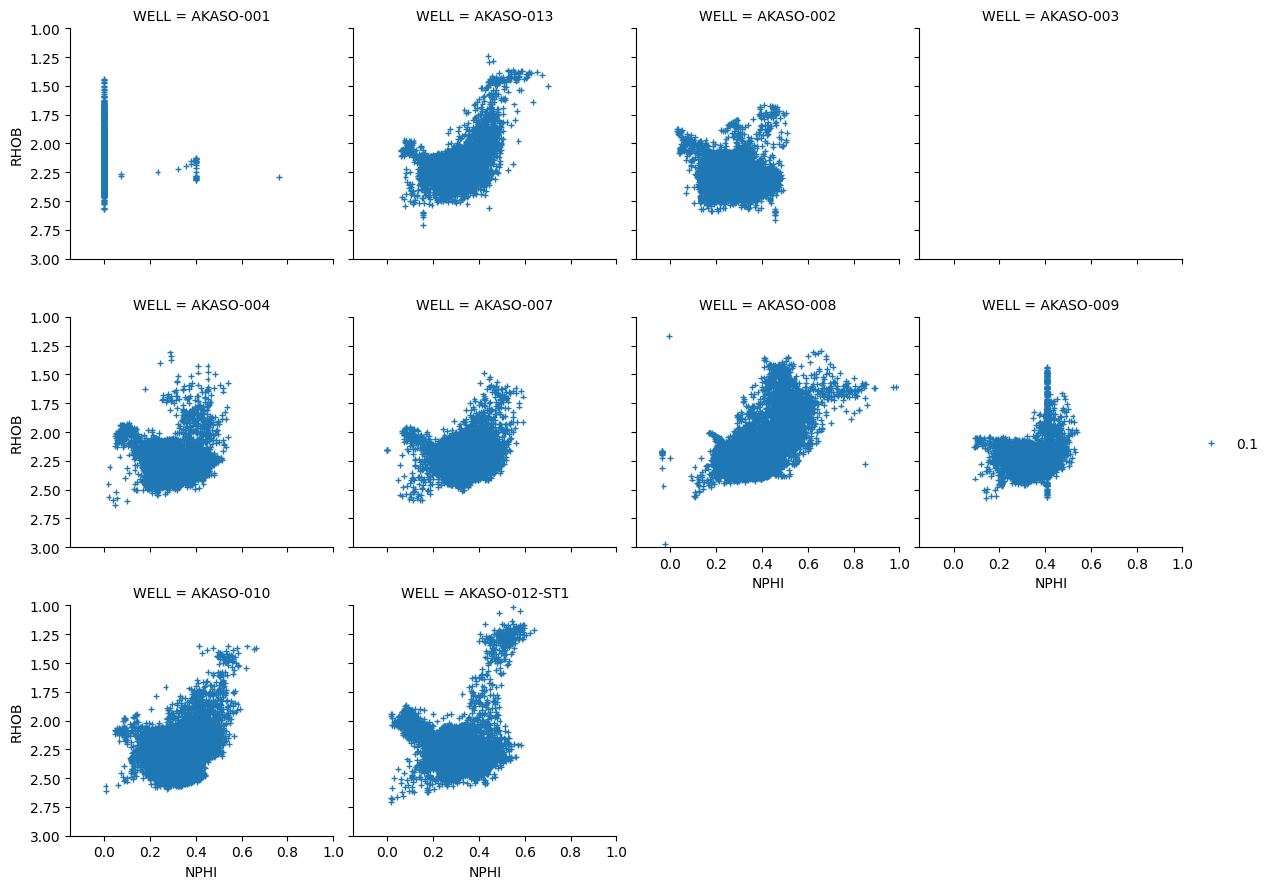

In [18]:
g = sns.FacetGrid(wells_3, col='WELL', col_wrap=4)
g.map(sns.scatterplot, 'NPHI', 'RHOB', linewidth=1, size=0.1, marker='+')
g.set(xlim=(-0.15, 1))
g.set(ylim=(3, 1))
g.add_legend()

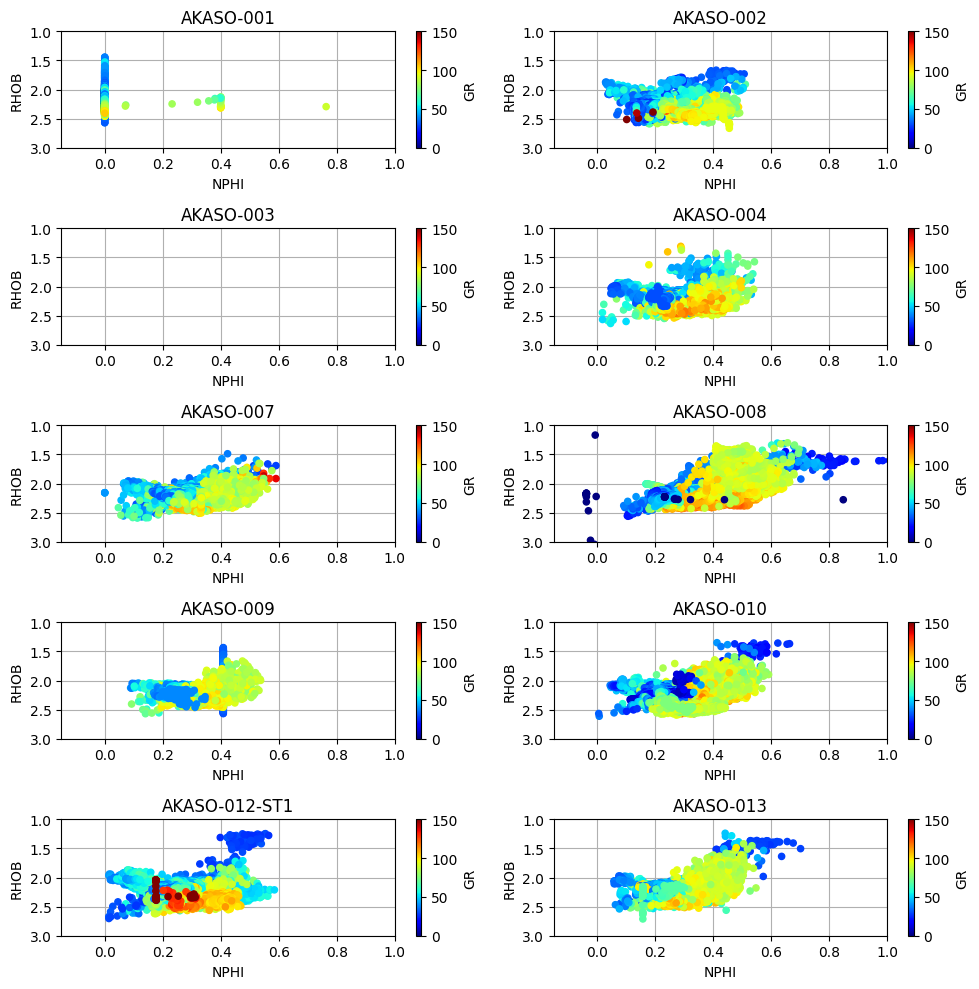

In [19]:
grouped = wells_3.groupby('WELL')
#Crossplot / Scatterplots Per Well¶
fig, axs = plt.subplots(5, 2, figsize=(10,10))

for (name, df), ax in zip(grouped, axs.flat):
    df.plot(kind='scatter', x='NPHI', y='RHOB', ax=ax, c='GR', cmap='jet', vmin=0, vmax=150)
    ax.set_xlim(-0.15,1)
    ax.set_ylim(3,1)
    ax.set_title(name)
    ax.grid(True)
    ax.set_axisbelow(True)
plt.tight_layout()

In [72]:
well_name = wells_3["WELL"].unique().tolist()
property_list = list(wells_3.columns)
property_list.remove('WELL')

def cross_plot(well, property1, property2, property3):

    '''
    Function to cross-plot well logs
    '''
    plt.scatter(wells_3[str(property1)][wells_3['WELL']==str(well)],wells_3[str(property2)][wells_3['WELL']==str(well)],
                c=wells_3[property3][wells_3['WELL']==str(well)],cmap=plt.cm.jet)
    plt.title(f"{property1} vs. {property2} color_coded with {property3} at well {well}")
    plt.xlabel(f"{property1}")
    plt.ylabel(f"{property2}")
    plt.legend([str(property3)],loc='upper right')
    plt.colorbar()
    plt.grid()
    plt.show()

In [75]:
from tkinter import *
from tkinter import filedialog
import ipywidgets as widgets
from ipywidgets import interact
@interact(property=widgets.SelectionSlider(options=property_list, description='Colour_Code'))
def interactive_colorcoded_crossplot(property, Well_Name=well_name, X_Axis=wells_3, Y_Axis=wells_3):   
    cross_plot(Well_Name, X_Axis, Y_Axis, property)

interactive(children=(SelectionSlider(description='Colour_Code', options=('DEPTH', 'GR', 'LLD', 'RHOB', 'NPHI'…

## The Seaborn PairPlot
The Seaborn library also has a very powerful visualisation known as a pairplot which can be called through a single line of code. This allows us to compare, on a grid, multiple columns/measurements against the others. The equivalent code in matplotlib would extend several lines.

Prior to displaying the pairplot we need to modify the data we are using. Firstly, we will work with a subset of the data consisting of some commonly used well logs. If we used all of the columns in the example for this article, we would be unable to view the details. Secondly, we need to drop any missing data values, otherwise issues can arise when plotting.


In [20]:
wells_clean = wells_3.copy()

In [21]:
wells_clean = wells_clean.dropna()

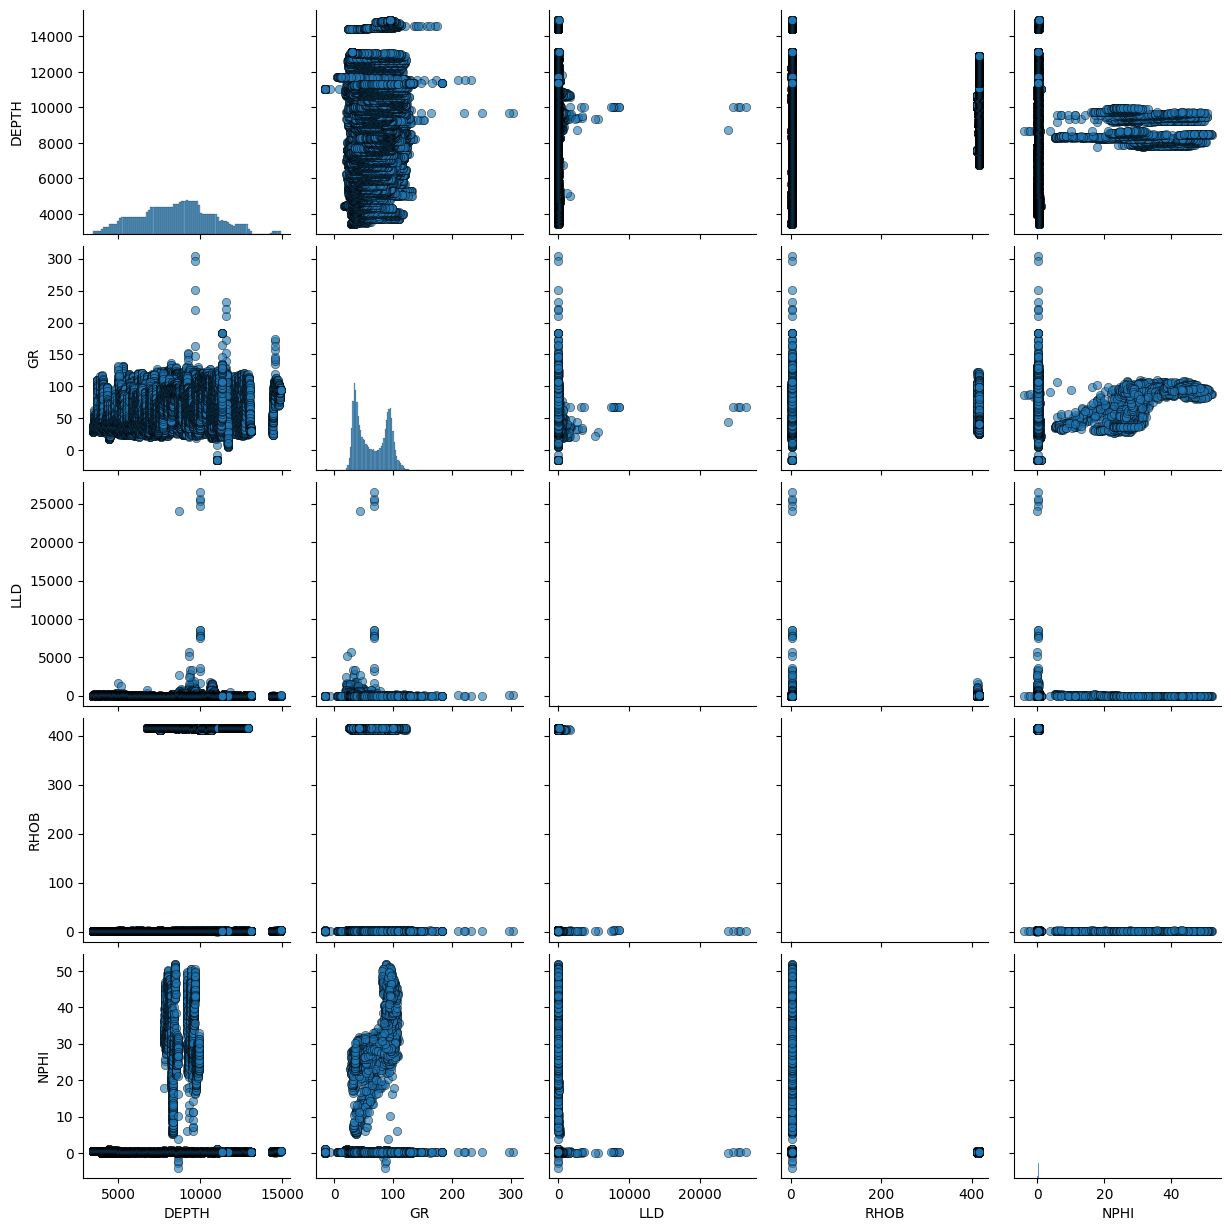

In [22]:
sns.pairplot(wells_clean, diag_kind='hist', plot_kws={'alpha':0.6, 'edgecolor':'k'})

This produces multiple scatter plots with a histogram of each of the curves along the diagonal. As you can see this allows us to quickly understand how data is distributed and correlated between the different logging curves. A very powerful plot!

In [23]:
wells_clean.describe()

,DEPTH,GR,LLD,RHOB,NPHI
count,107173.00000,107173.000000,107173.000000,107173.000000,107173.000000
mean,8538.43399,64.716469,18.490325,47.423866,1.257666
std,2223.59357,26.621454,194.647503,129.049608,5.747499
min,3447.00000,-14.785700,0.065100,0.255100,-4.026700
25%,6977.00000,38.740300,1.525300,2.138800,0.233100
50%,8620.00000,61.297900,2.282300,2.206800,0.287100
75%,9993.00000,90.750000,10.197700,2.333100,0.380100
max,14921.00000,304.205900,26536.019500,416.000000,52.006200


## Identifying Outliers with Boxplots

## What are Boxplots?
A boxplot is a graphical and standardised way to display the distribution of data based on five key numbers: The "minimum", 1st Quartile (25th percentile), median (2nd Quartile./ 50th Percentile), the 3rd Quartile (75th percentile) and the "maximum". The minimum and maximum values are defined as Q1 - 1.5 * IQR and Q3 + 1.5 * IQR respectively. Any points that fall outside of these limits are referred to as outliers.

Boxplots can be used to:

Identify outliers or anomalous data points
To determine if our data is skewed
To understand the spread/range of the data
To construct a boxplot, we first start with the median value / 50th percentile (Q2). This represents the middle value within our data.

A box is then formed between the 25th and 75th percentiles (Q1 and Q3 respectively). The range represented by this box is known as the inter-quartile range (IQR).

From this box extends lines, which are also knwon as the whiskers. These extend to Q1 - 1.5 * IQR and Q3 + 1.5 * IQR or to the last data point if it is less than this value.

Any points that fall beyond the whisker limits are known as outliers.

In order to work with some of the matplotlib plots, it is necessary to remove missing values which are represented by NaN. We can remove these by using .dropna(). Adding inplace=True allows us to remove these from the original dataframe rather than a copy of it.

## Simple Box Plots Using Pandas
Now that our data has been loaded we can generate our very first boxplot. We can do this by typing df['GR'] which selects the GR column from the dataframe, followed by .plot().

Within the arguments for the plot method, we pass in kind=box to tell the function we want a boxplot.

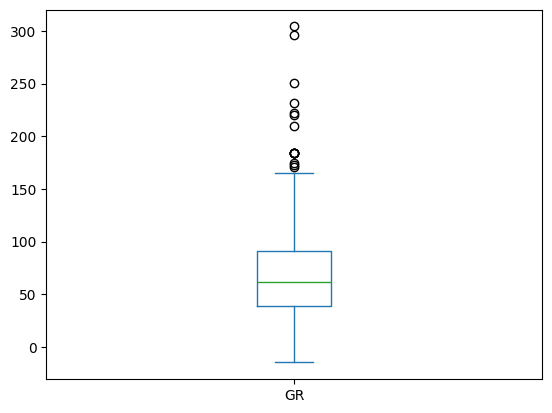

In [24]:
#Simple boxplot using pandas
wells_clean['GR'].plot(kind='box');

When we run this cell, we get a very basic looking box plot. We have the inter quartile range box, which contains the median line. Extending from either side are the whiskers which extend to 1.5 times the inter quartile range. And then at the top here we have a series of circles, which represent outliers.

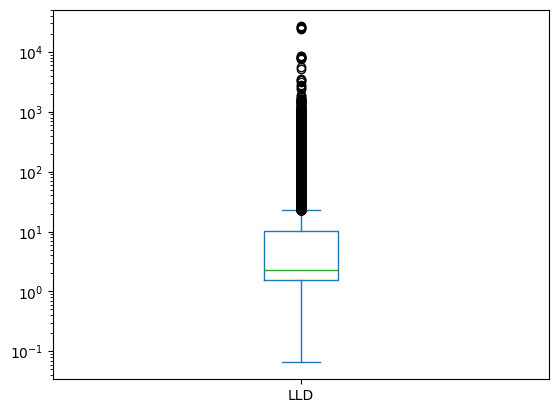

In [25]:
#Viewing logarithmically scaled data
wells_clean['LLD'].plot(kind='box')
plt.semilogy();

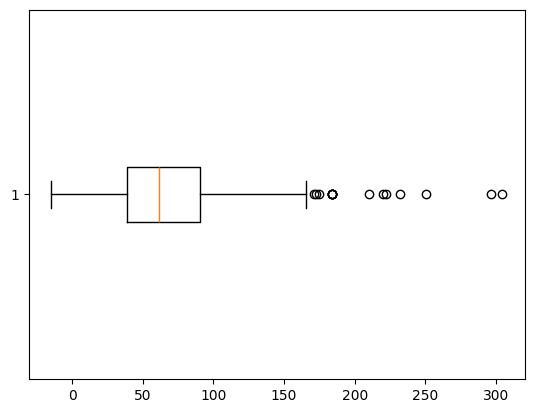

In [26]:
#Using matplotlib to make a boxplot
plt.boxplot(x=wells_clean['GR'], vert=False);

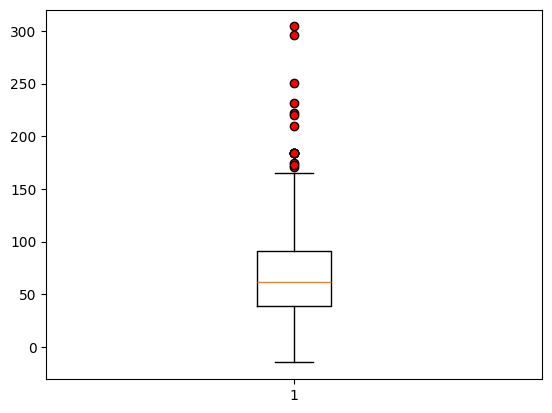

In [27]:
#Changing the outlier markers
red_circle = dict(markerfacecolor='red', marker='o')
plt.boxplot(x=wells_clean['GR'], vert=True, flierprops=red_circle);

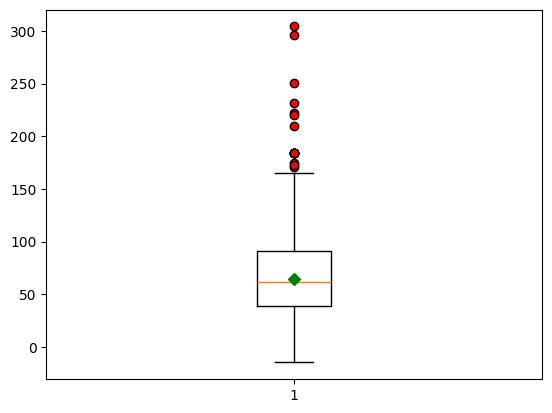

In [28]:
#Adding the mean
red_circle = dict(markerfacecolor='red', marker='o')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')

plt.boxplot(x=wells_clean['GR'], vert=True, flierprops=red_circle, 
             showmeans=True, meanprops=mean_shape);

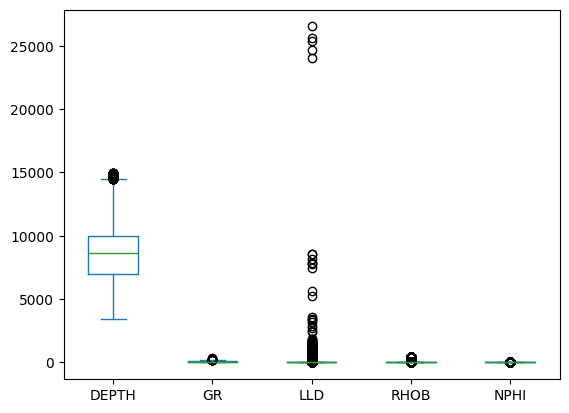

In [29]:
#Displaying all columns in the dataframe on a single figure
wells_clean.plot(kind='box');

This generates a plot with all of our columns, but it is not very appealing. Also, all of our measurements are on different measurement ranges. GR can typically range from 0 to 200 API, whereas DEN typically ranges from about 1.5 g/cc to around 3 g/cc.

This can make it very difficult to read and identify outliers within the data. To make boxplots with different y-axes and to make a figure that is readable as well as useable we need to use subplots. If you want to find out more about subplots in matplotlib, please check out my previous video which covers subplot2grid.

First we start be defining our outliers as a red underscore circle.

red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')
We then define fig, axs as plt.subplots. In the arguments we pass in that we want 1 row, and then the number of columns. The number of columns will be equal to the length of df.columns. Finally, we will set the figsize to 20 by 10.

fig, axs = plt.subplots(1, len(df.columns), figsize=(20,10))
We then need to create a small for loop which will loop over each of our plot axes. We are using the enumerate function here to keep track of i, our index value.

for i, ax in enumerate(axs.flat):
Next we can add in our boxplot by calling upon ax.boxplot() and passing in df.iloc, which allows us to get columns by the index variable, i. We do this by creating square brackets, with a colon followed by a comma. This tells the iloc function to get all rows, and then we pass in the column index. Next we specify our outlier properties and pass in red_circle.

 ax.boxplot(df.iloc[:,i], flierprops=red_circle)
The next couple of lines allows us to set the title and the y tick label font size. At the end we call upon plt.tight_layout to space out the plots in a nice way.

In [30]:
# remove the DEPTH column
plot_cols = [ 'GR', 'LLD', 'RHOB', 'NPHI']
wells_clean2 = wells_clean[plot_cols]

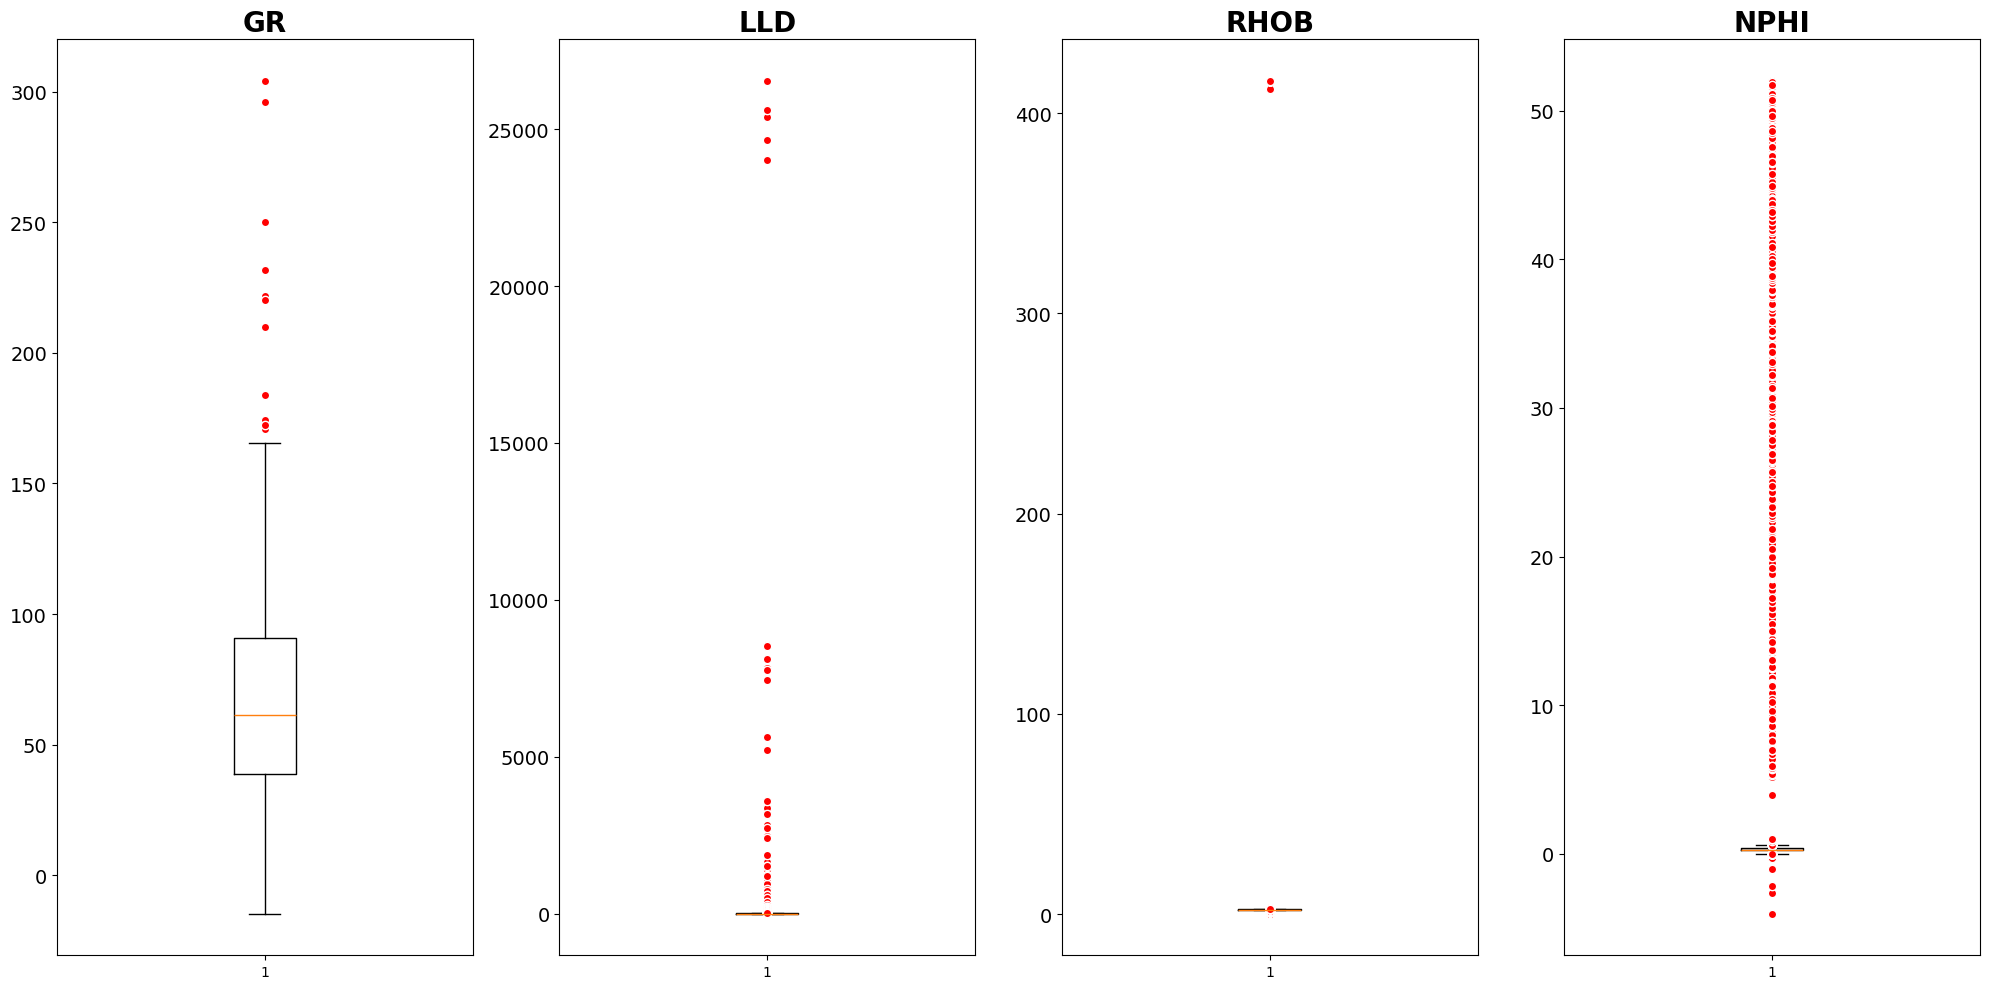

In [31]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(wells_clean2.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(wells_clean2.iloc[:,i], flierprops=red_circle)
    ax.set_title(wells_clean2.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

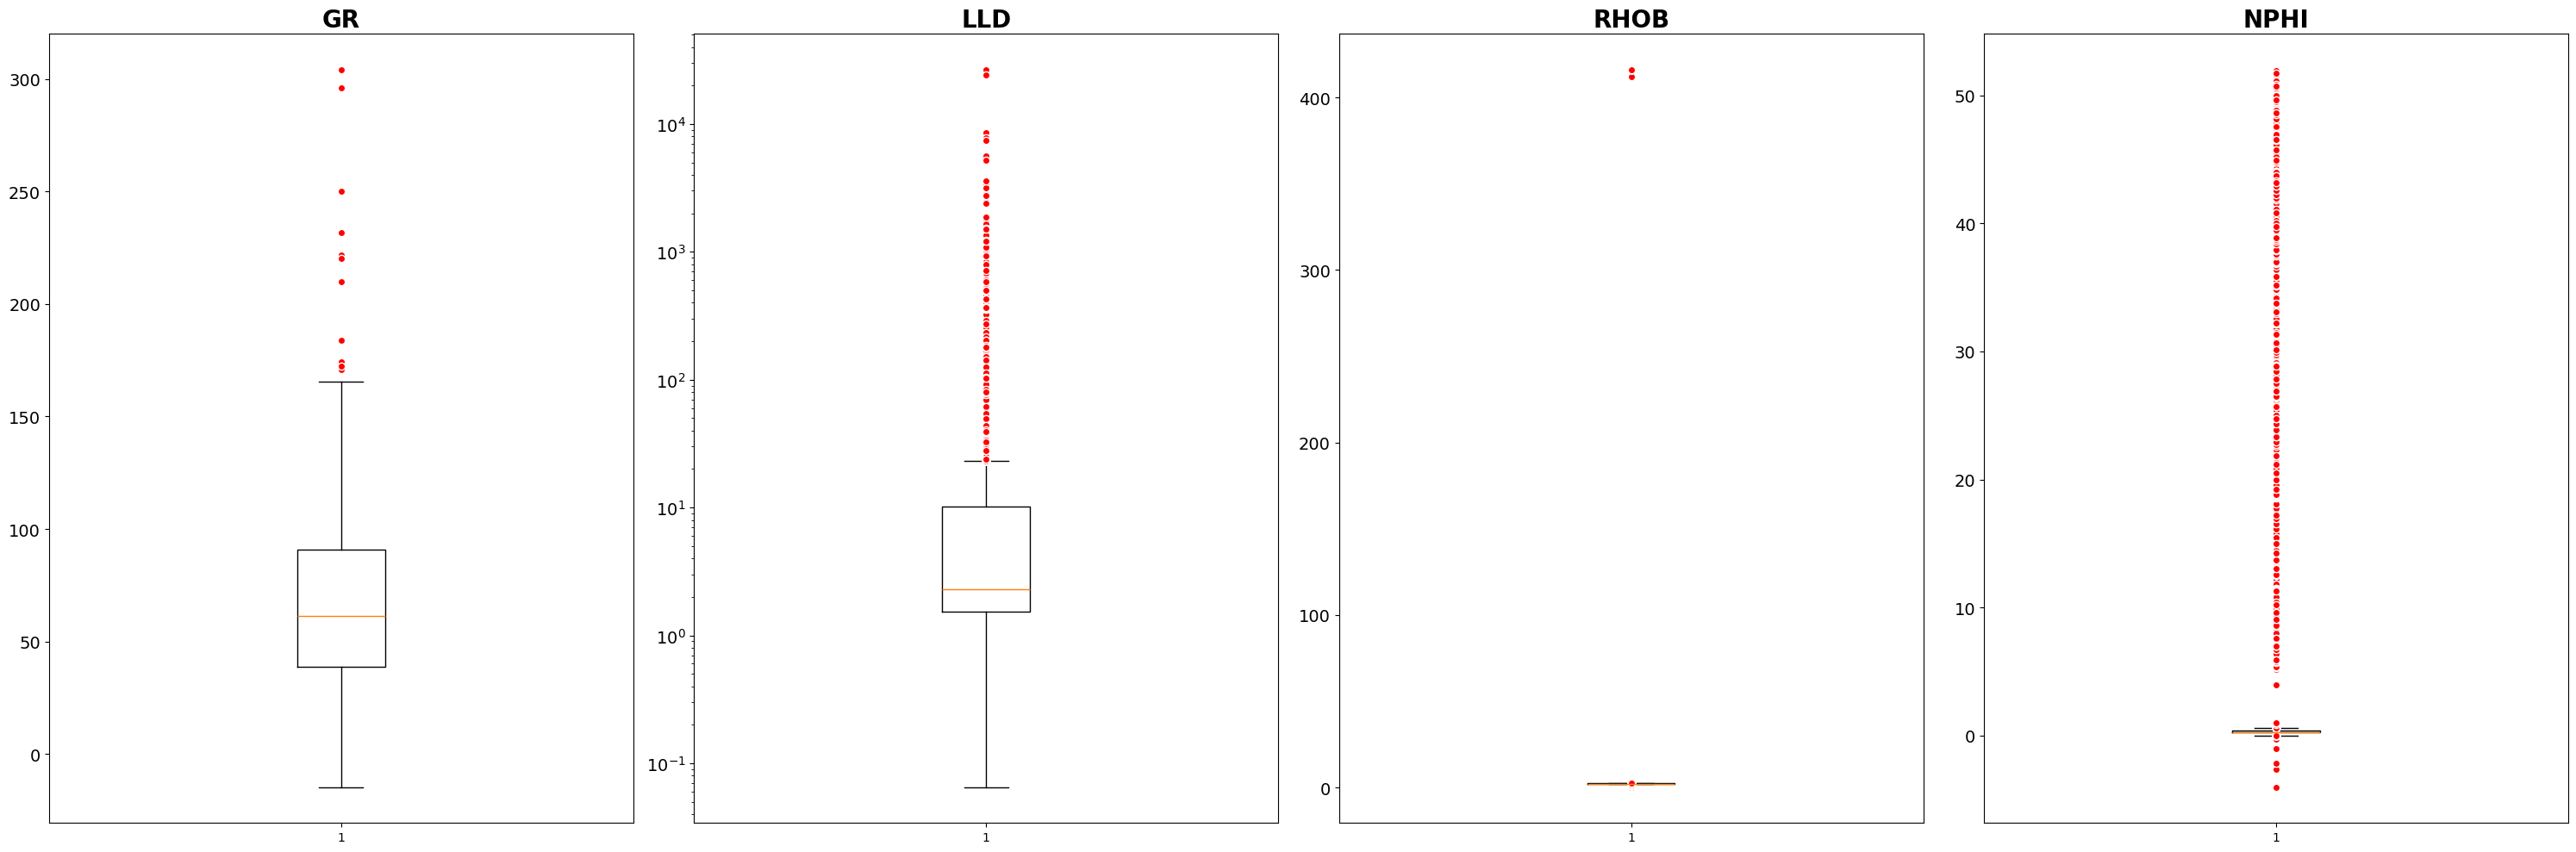

In [32]:
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(wells_clean2.columns), figsize=(30,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(wells_clean2.iloc[:,i], flierprops=red_circle)
    wells_clean2.iloc[:,i]
    ax.set_title(wells_clean2.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
    #Checking if column names are equal to columns we expect to be logarithmic
    if wells_clean2.columns[i] == 'LLD' :
        ax.semilogy()
    
plt.tight_layout()

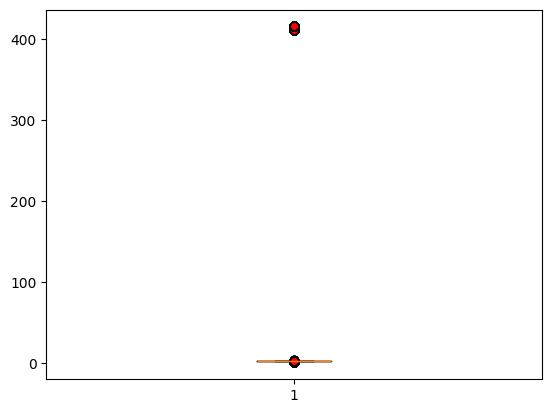

In [33]:
red_circle = dict(markerfacecolor='red', marker='o')
plt.boxplot(x=wells_clean['RHOB'], vert=True, flierprops=red_circle);

## Auto Outlier Detection - Isolation Forest

In [34]:
from sklearn.ensemble import IsolationForest

## Building an Isolation Forest Model (2 Features)

In [35]:
anomaly_inputs = ['NPHI', 'RHOB']

In [36]:
model_IF = IsolationForest(contamination=0.1, random_state=42)

In [37]:
model_IF.fit(wells_clean2[anomaly_inputs])

IsolationForest(contamination=0.1, random_state=42)

In [38]:
wells_clean2['anomaly_scores'] = model_IF.decision_function(wells_clean2[anomaly_inputs])

C:\Users\USER\AppData\Local\Temp\ipykernel_15428\3980641939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wells_clean2['anomaly_scores'] = model_IF.decision_function(wells_clean2[anomaly_inputs])


In [39]:
wells_clean2['anomaly'] = model_IF.predict(wells_clean2[anomaly_inputs])

In [40]:
wells_clean2.loc[:, ['NPHI', 'RHOB','anomaly_scores','anomaly'] ]

,NPHI,RHOB,anomaly_scores,anomaly
8020,0.0000,1.9300,-0.010920,-1
8021,0.0000,1.9300,-0.010920,-1
8022,0.0000,1.9300,-0.010920,-1
8023,0.0000,1.9300,-0.010920,-1
8024,0.0000,1.9300,-0.010920,-1
...,...,...,...,...
201729,0.3119,2.3408,0.180152,1
201730,0.3036,2.3361,0.184241,1
201731,0.3029,2.3390,0.186493,1
201732,0.2962,2.3178,0.185141,1


In [41]:
def outlier_plot(data, outlier_method_name, x_var, y_var, 
                 xaxis_limits=[0,1], yaxis_limits=[0,1]):
    
    print(f'Outlier Method: {outlier_method_name}')
    
    method = f'{outlier_method_name}_anomaly'
    
    print(f"Number of anomalous values {len(data[data['anomaly']==-1])}")
    print(f"Number of non anomalous values  {len(data[data['anomaly']== 1])}")
    print(f'Total Number of Values: {len(data)}')
    
    g = sns.FacetGrid(data, col='anomaly', height=4, hue='anomaly', hue_order=[1,-1])
    g.map(sns.scatterplot, x_var, y_var)
    g.fig.suptitle(f'Outlier Method: {outlier_method_name}', y=1.10, fontweight='bold')
    g.set(xlim=xaxis_limits, ylim=yaxis_limits)
    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{len(data[data['anomaly']== -1])} points")
    axes[1].set_title(f"Inliers\n {len(data[data['anomaly']==  1])} points")
    return g

Outlier Method: Isolation Forest
Number of anomalous values 10712
Number of non anomalous values  96461
Total Number of Values: 107173


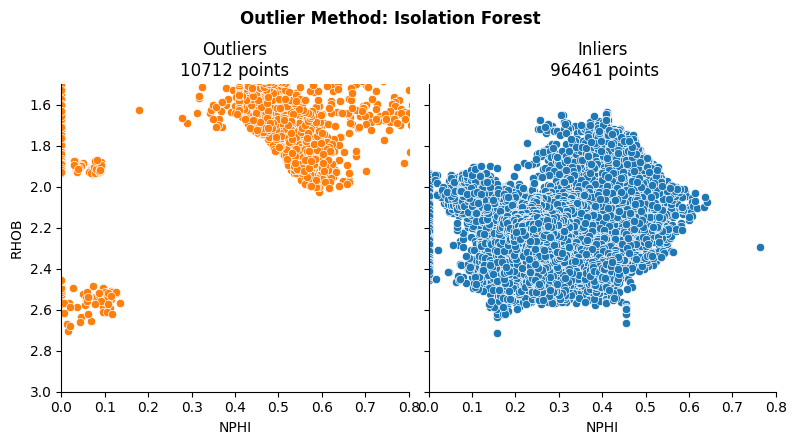

In [42]:
outlier_plot(wells_clean2, 'Isolation Forest', 'NPHI', 'RHOB', [0, 0.8], [3, 1.5])

## Building an Isolation Forest Model Using Multiple Features

In [43]:
anomaly_inputs = ['NPHI' ,'RHOB', 'GR', 'LLD']

In [44]:
anomaly_inputs = ['NPHI', 'RHOB', 'GR', 'LLD']
model_IF = IsolationForest(contamination=0.1, random_state=42)
model_IF.fit(wells_clean2[anomaly_inputs])
wells_clean2['anomaly_scores'] = model_IF.decision_function(wells_clean2[anomaly_inputs])
wells_clean2['anomaly'] = model_IF.predict(wells_clean2[anomaly_inputs])


Outlier Method: Isolation Forest
Number of anomalous values 10718
Number of non anomalous values  96455
Total Number of Values: 107173


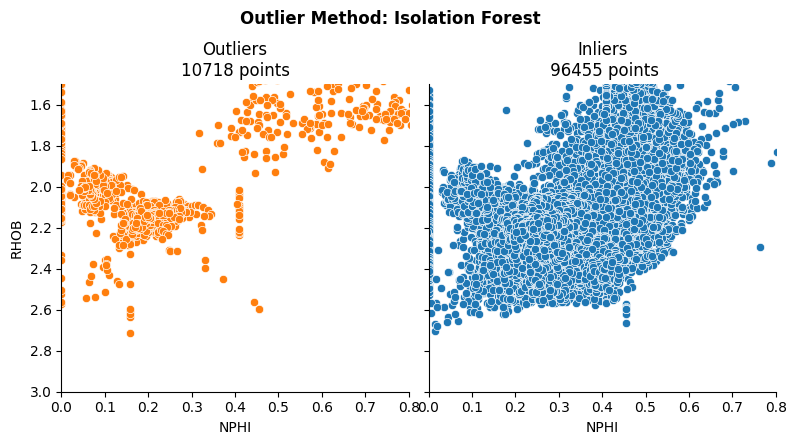

In [45]:
outlier_plot(wells_clean2, 'Isolation Forest', 'NPHI', 'RHOB', [0, 0.8], [3, 1.5]);

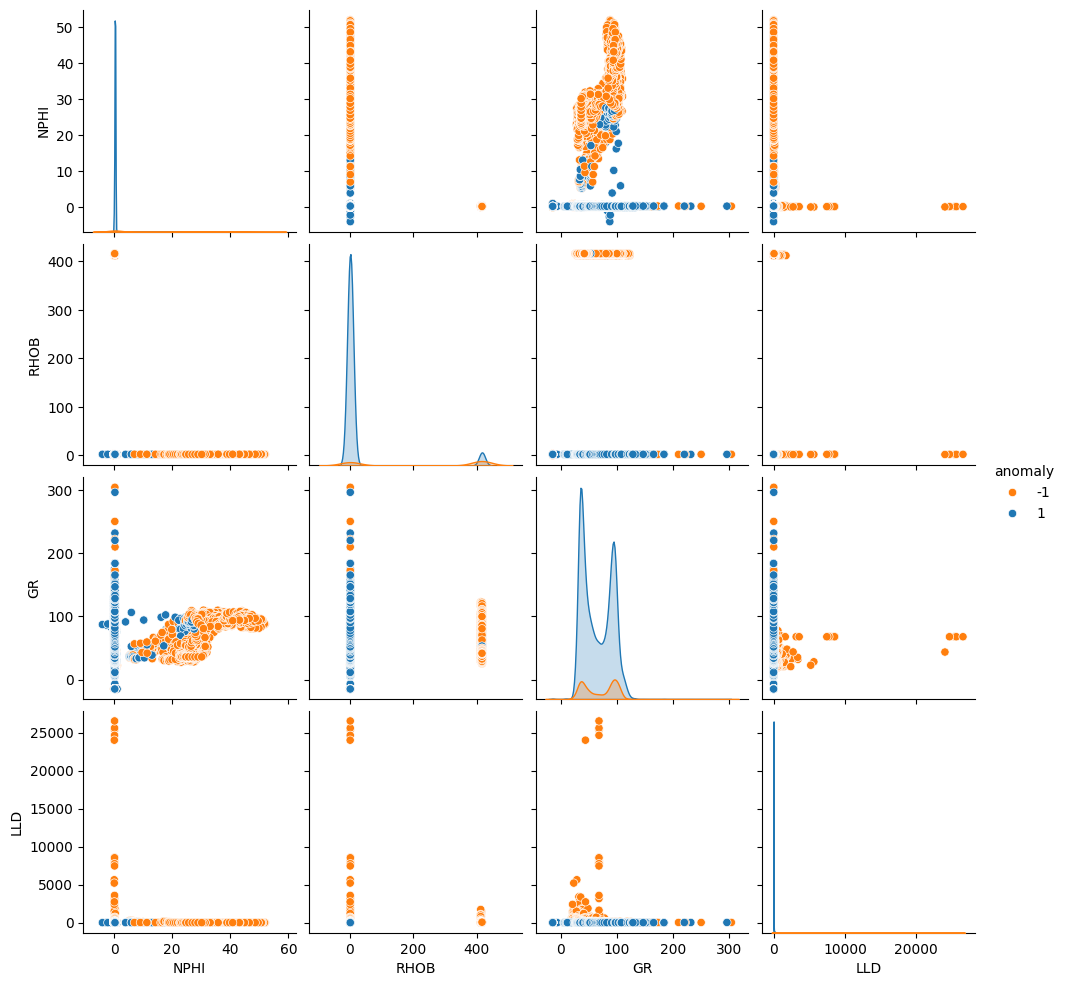

In [46]:
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(wells_clean2, vars=anomaly_inputs, hue='anomaly', palette=palette)

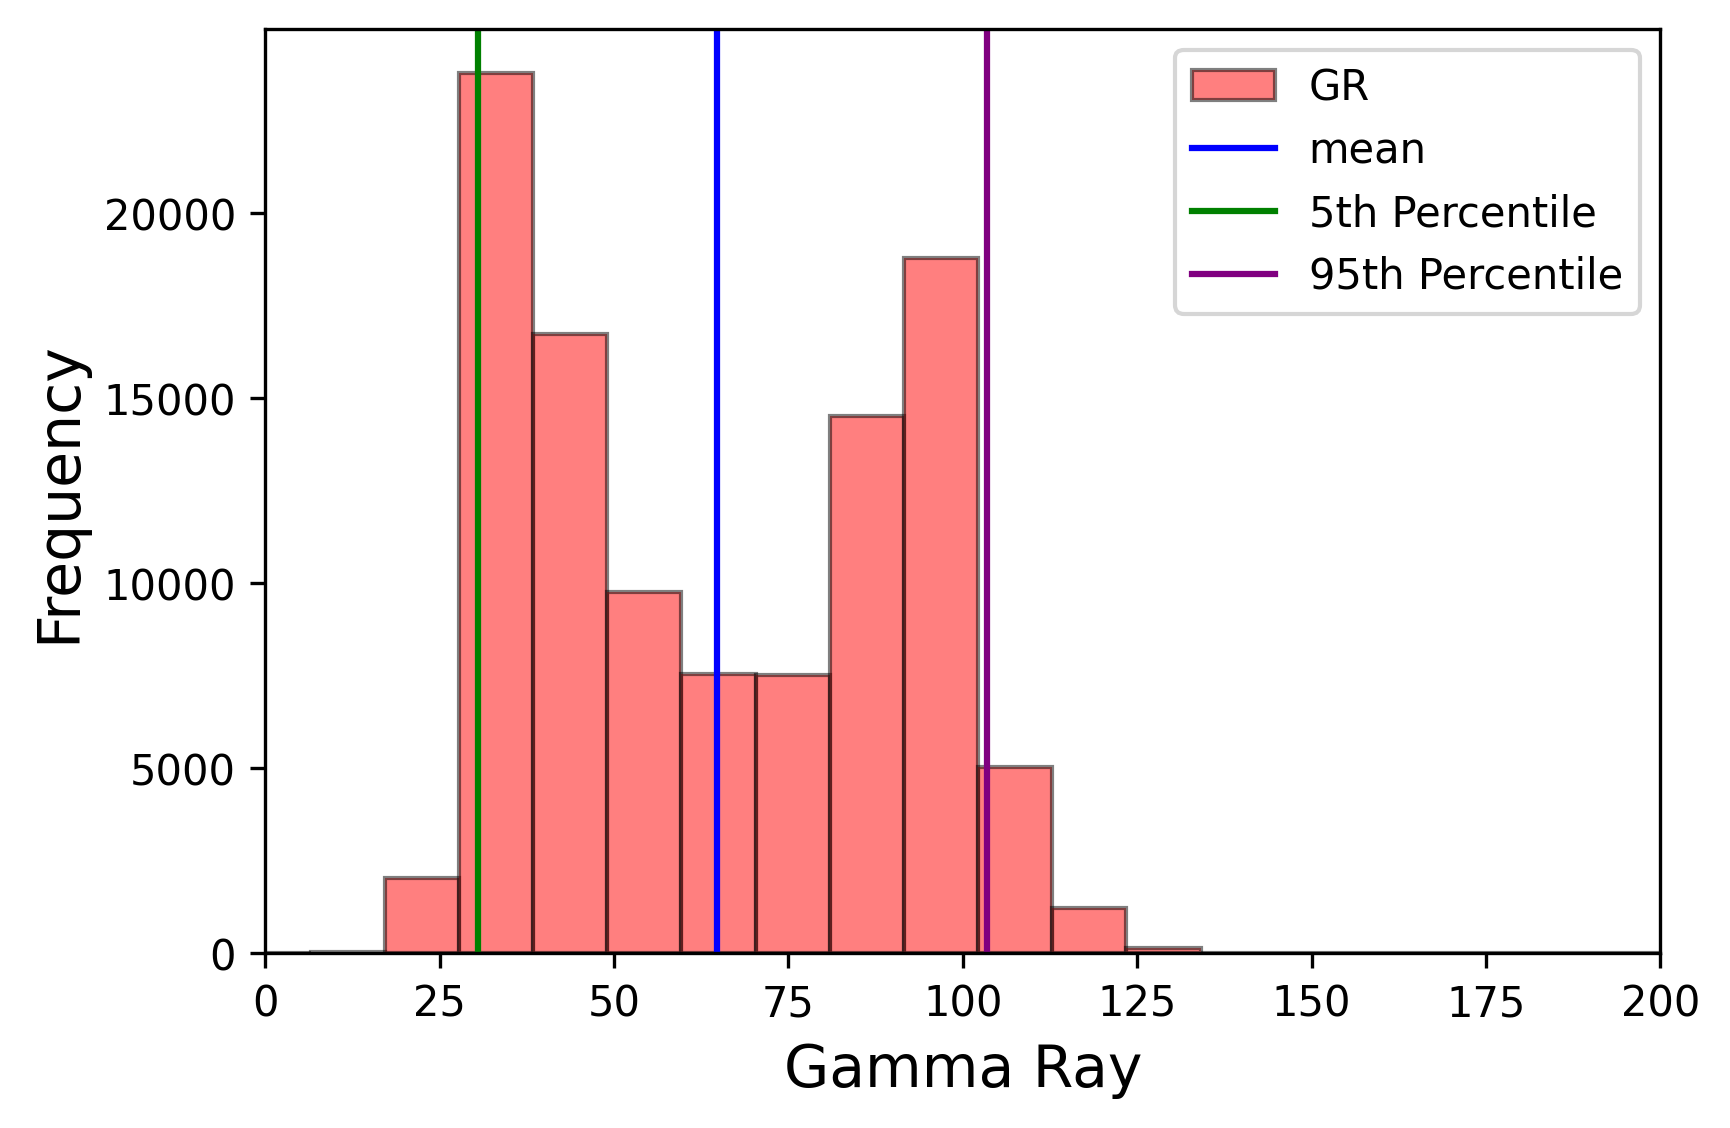

In [47]:
mean = wells_clean2['GR'].mean()
p5 = wells_clean2['GR'].quantile(0.05)
p95 = wells_clean2['GR'].quantile(0.95)

plt.figure(figsize=(6,4), dpi=300)
wells_clean2['GR'].plot(kind='hist', bins=30, color='red', alpha=0.5, edgecolor='black')
plt.xlabel('Gamma Ray', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(0,200)

plt.axvline(mean, color='blue', label='mean')
plt.axvline(p5, color='green', label='5th Percentile')
plt.axvline(p95, color='purple', label='95th Percentile')

plt.legend()
plt.show()

array([[<Axes: title={'center': 'NPHI'}>]], dtype=object)

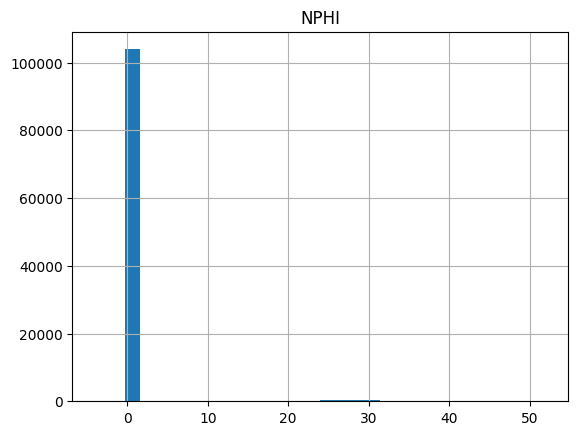

In [48]:
wells_clean2.hist(column="NPHI", bins = 30)

## Remove Outliers

In [49]:
wells_clean3 = wells_clean2.copy()

In [50]:
# Remove Outliers
Q1 = wells_clean3.quantile(0.25)
Q3 = wells_clean3.quantile(0.75)
IQR = Q3 - Q1
df_cleaned = wells_clean3[~((wells_clean3 < (Q1 - 1.5 * IQR)) | (wells_clean3 > (Q3 + 1.5 * IQR))).any(axis=1)]


In [51]:
df_cleaned

,GR,LLD,RHOB,NPHI,anomaly_scores,anomaly
15598,77.3045,1.4997,2.2656,0.0723,0.154716,1
17313,89.7565,1.4191,2.2873,0.4000,0.173828,1
17314,95.4250,1.3932,2.2981,0.4000,0.164602,1
17315,98.9561,1.4191,2.3141,0.4000,0.158933,1
17316,99.6995,1.3552,2.3143,0.4000,0.157861,1
...,...,...,...,...,...,...
201723,129.5191,1.7509,2.3306,0.3163,0.080707,1
201724,133.0938,1.6740,2.3369,0.3034,0.083147,1
201725,128.3808,1.6653,2.3327,0.3037,0.084189,1
201726,146.7920,1.8356,2.3367,0.2989,0.080486,1


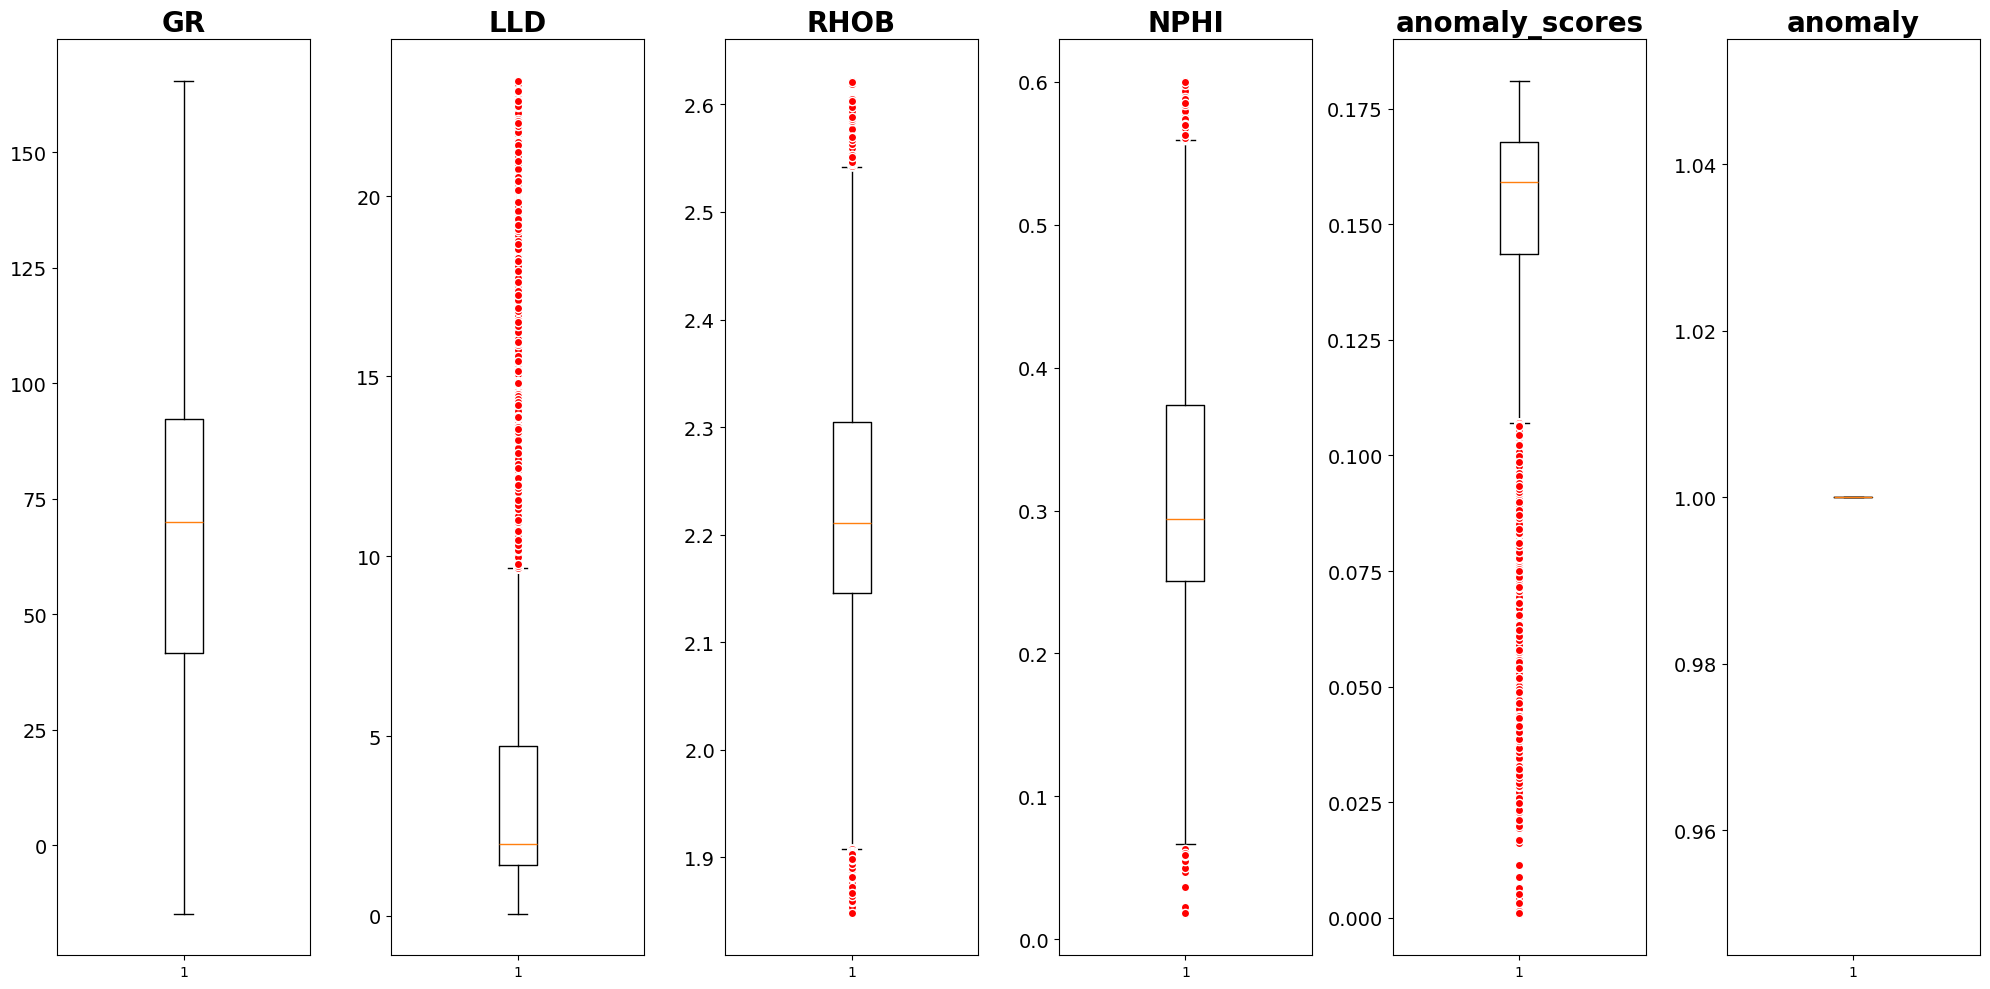

In [52]:
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(df_cleaned.columns), figsize=(20,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df_cleaned.iloc[:,i], flierprops=red_circle)
    ax.set_title(df_cleaned.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

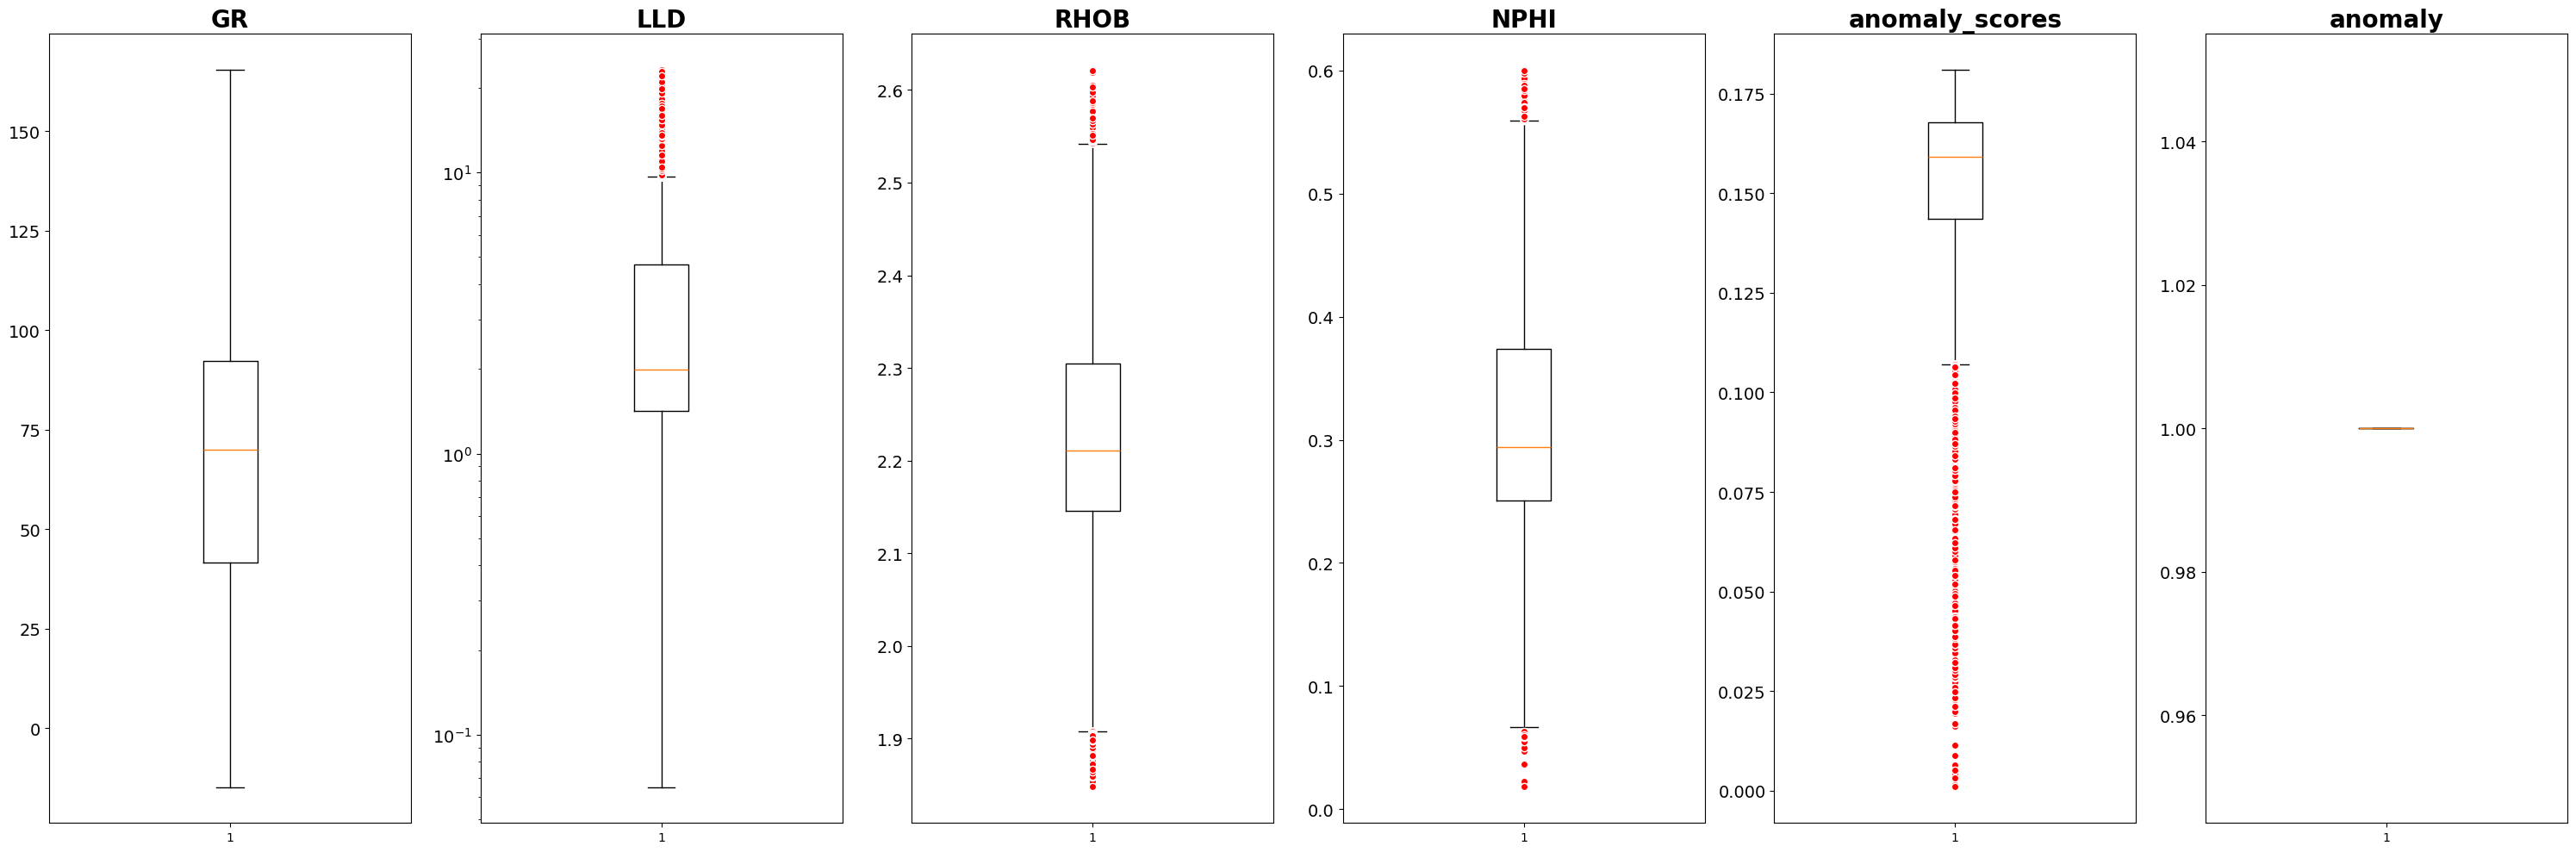

In [53]:
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(df_cleaned.columns), figsize=(30,10))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df_cleaned.iloc[:,i], flierprops=red_circle)
    df_cleaned.iloc[:,i]
    ax.set_title(df_cleaned.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
    #Checking if column names are equal to columns we expect to be logarithmic
    if df_cleaned.columns[i] == 'LLD' :
        ax.semilogy()
    
plt.tight_layout()

In [54]:
name = wells_clean['DEPTH']
df_cleaned = pd.concat([df_cleaned, name], axis=1)

In [55]:
df_cleaned

,GR,LLD,RHOB,NPHI,anomaly_scores,anomaly,DEPTH
15598,77.3045,1.4997,2.2656,0.0723,0.154716,1.0,7799.0
17313,89.7565,1.4191,2.2873,0.4000,0.173828,1.0,8656.5
17314,95.4250,1.3932,2.2981,0.4000,0.164602,1.0,8657.0
17315,98.9561,1.4191,2.3141,0.4000,0.158933,1.0,8657.5
17316,99.6995,1.3552,2.3143,0.4000,0.157861,1.0,8658.0
...,...,...,...,...,...,...,...
201729,NaN,NaN,NaN,NaN,NaN,NaN,11367.5
201730,NaN,NaN,NaN,NaN,NaN,NaN,11368.0
201731,NaN,NaN,NaN,NaN,NaN,NaN,11368.5
201732,NaN,NaN,NaN,NaN,NaN,NaN,11369.0


In [56]:
name = wells_clean['WELL']
df_cleaned = pd.concat([df_cleaned, name], axis=1)

In [57]:
df_cleaned['WELL'].unique()

array(['AKASO-001', 'AKASO-013', 'AKASO-002', 'AKASO-004', 'AKASO-007',
       'AKASO-008', 'AKASO-009', 'AKASO-010', 'AKASO-012-ST1',
       'AKASO-003'], dtype=object)

In [58]:
df_cleaned2 = df_cleaned.dropna()

In [59]:
df_cleaned2['WELL'].unique()

array(['AKASO-001', 'AKASO-013', 'AKASO-002', 'AKASO-004', 'AKASO-007',
       'AKASO-008', 'AKASO-009', 'AKASO-010', 'AKASO-012-ST1'],
      dtype=object)

In [60]:
df_cleaned2

,GR,LLD,RHOB,NPHI,anomaly_scores,anomaly,DEPTH,WELL
15598,77.3045,1.4997,2.2656,0.0723,0.154716,1.0,7799.0,AKASO-001
17313,89.7565,1.4191,2.2873,0.4000,0.173828,1.0,8656.5,AKASO-001
17314,95.4250,1.3932,2.2981,0.4000,0.164602,1.0,8657.0,AKASO-001
17315,98.9561,1.4191,2.3141,0.4000,0.158933,1.0,8657.5,AKASO-001
17316,99.6995,1.3552,2.3143,0.4000,0.157861,1.0,8658.0,AKASO-001
...,...,...,...,...,...,...,...,...
201723,129.5191,1.7509,2.3306,0.3163,0.080707,1.0,11364.5,AKASO-012-ST1
201724,133.0938,1.6740,2.3369,0.3034,0.083147,1.0,11365.0,AKASO-012-ST1
201725,128.3808,1.6653,2.3327,0.3037,0.084189,1.0,11365.5,AKASO-012-ST1
201726,146.7920,1.8356,2.3367,0.2989,0.080486,1.0,11366.0,AKASO-012-ST1


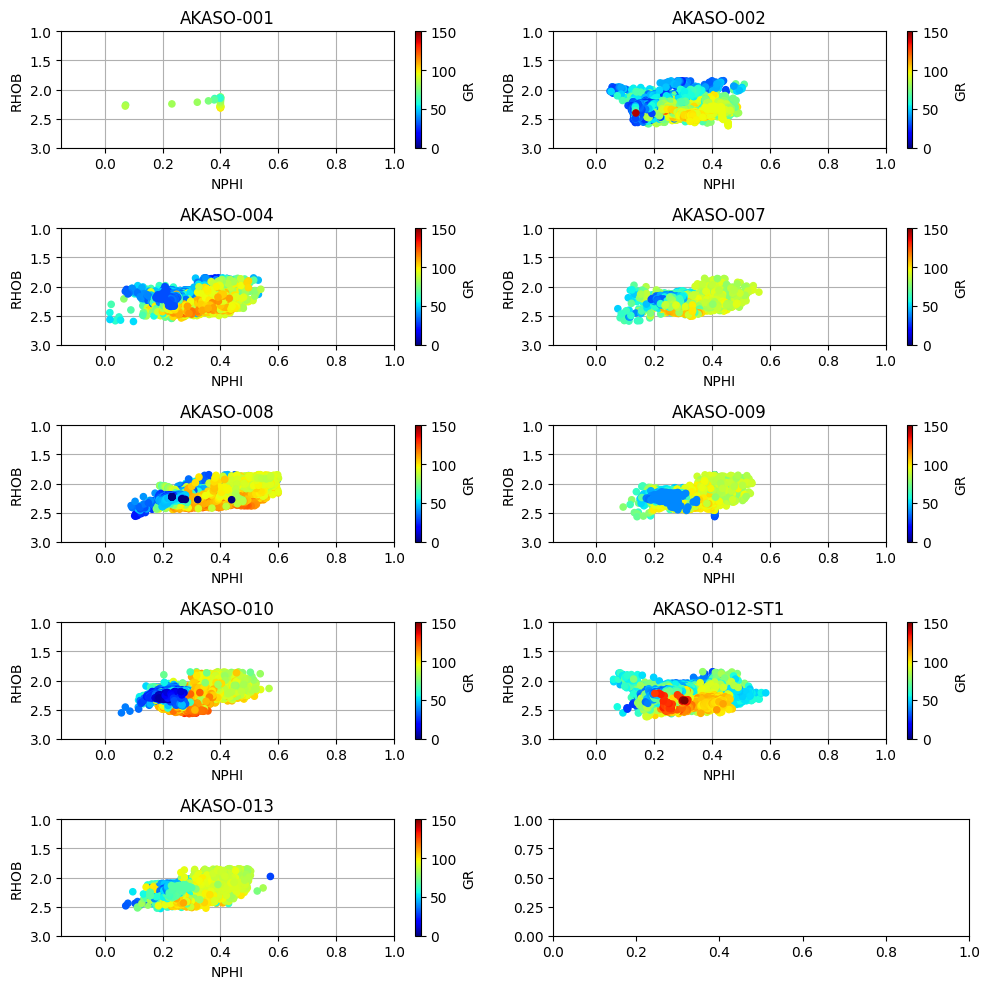

In [61]:
grouped = df_cleaned2.groupby('WELL')
#Crossplot / Scatterplots Per Well¶
fig, axs = plt.subplots(5, 2, figsize=(10,10))

for (name, df), ax in zip(grouped, axs.flat):
    df.plot(kind='scatter', x='NPHI', y='RHOB', ax=ax, c='GR', cmap='jet', vmin=0, vmax=150)
    ax.set_xlim(-0.15,1)
    ax.set_ylim(3,1)
    ax.set_title(name)
    ax.grid(True)
    ax.set_axisbelow(True)
plt.tight_layout()

In [62]:
df_cleaned2.columns.values

array(['GR', 'LLD', 'RHOB', 'NPHI', 'anomaly_scores', 'anomaly', 'DEPTH',
       'WELL'], dtype=object)

In [63]:
wells_clean3 = df_cleaned2.drop(['anomaly_scores', 'anomaly'], axis =1)

In [64]:
wells_clean3

,GR,LLD,RHOB,NPHI,DEPTH,WELL
15598,77.3045,1.4997,2.2656,0.0723,7799.0,AKASO-001
17313,89.7565,1.4191,2.2873,0.4000,8656.5,AKASO-001
17314,95.4250,1.3932,2.2981,0.4000,8657.0,AKASO-001
17315,98.9561,1.4191,2.3141,0.4000,8657.5,AKASO-001
17316,99.6995,1.3552,2.3143,0.4000,8658.0,AKASO-001
...,...,...,...,...,...,...
201723,129.5191,1.7509,2.3306,0.3163,11364.5,AKASO-012-ST1
201724,133.0938,1.6740,2.3369,0.3034,11365.0,AKASO-012-ST1
201725,128.3808,1.6653,2.3327,0.3037,11365.5,AKASO-012-ST1
201726,146.7920,1.8356,2.3367,0.2989,11366.0,AKASO-012-ST1


# Calculate IQR
Q1 = np.percentile(data_with_outliers, 25)
Q3 = np.percentile(data_with_outliers, 75)
IQR = Q3 - Q1

# Define outlier boundaries using IQR method
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers using IQR method
outliers_iqr = data_with_outliers[(data_with_outliers < lower_bound) | (data_with_outliers > upper_bound)]

print("Detected outliers using IQR:")
print(outliers_iqr)

# Removing Outliers with IQR
non_outliers = data_with_outliers[(data_with_outliers >= lower_bound) & (data_with_outliers <= upper_bound)]

print(f'Data size before removal: {len(data_with_outliers)}')
print(f'Data size after removal: {len(non_outliers)}')


## How to remove rows with specific string

wells_clean['WELL'].unique()

wells_clean3 = wells_clean[wells_clean["WELL"].str.contains("AKASO-003")==False]

wells_clean.info()

wells_clean3.info()

wells_clean3['WELL'].unique()

## Add a column from one dataframe to other

wells_clean

wells_clean2

depth = wells_clean['DEPTH']

wells_clean3 = pd.concat([wells_clean2, depth], axis=1)

wells_clean3

wells_clean3.columns.values

columns_name = ['DEPTH', 'CAL', 'GR', 'LLD', 'RHOB', 'NPHI', 'SONIC', 'anomaly_scores',
       'anomaly']

wells_clean3.columns = columns_name

wells_clean3

## How to drop column

df = df.drop(['CAL'], axis =1)

## What is Normalization?
Normalization is the process of re-scaling or re-calibrating the well logs so that they are consistent with other logs in other wells within the field. This can be achieved by applying a single point normalization (linear shift) or a two point normalization ('stretch and squeeze') to the required curve.

Normalization is commonly applied to gamma ray logs, but can be applied to neutron porosity, bulk density, sonic and spontaneous potential logs. Resistivity logs are generally not normalized unless there is a sufficient reason to do so (Shier, 2004). It should be noted that applying normalization can remove geological variations and features across the study area and should be considered carefully. Shier (2004) provides an excellent discus

In [65]:
wells_clean3['WELL'].unique()

array(['AKASO-001', 'AKASO-013', 'AKASO-002', 'AKASO-004', 'AKASO-007',
       'AKASO-008', 'AKASO-009', 'AKASO-010', 'AKASO-012-ST1'],
      dtype=object)

In [66]:
wells_clean4 = wells_clean3.groupby('WELL')
wells_clean4.head()

,GR,LLD,RHOB,NPHI,DEPTH,WELL
15598,77.3045,1.4997,2.2656,0.0723,7799.0,AKASO-001
17313,89.7565,1.4191,2.2873,0.4000,8656.5,AKASO-001
17314,95.4250,1.3932,2.2981,0.4000,8657.0,AKASO-001
17315,98.9561,1.4191,2.3141,0.4000,8657.5,AKASO-001
17316,99.6995,1.3552,2.3143,0.4000,8658.0,AKASO-001
23183,28.4794,0.4757,1.9815,0.5726,4996.0,AKASO-013
23222,33.6239,18.4695,2.1847,0.2583,5015.5,AKASO-013
23223,34.3810,13.7618,2.1739,0.2547,5016.0,AKASO-013
23224,34.1200,11.6313,2.1745,0.2419,5016.5,AKASO-013
23225,39.4524,12.5687,2.1970,0.2478,5017.0,AKASO-013


In [67]:
wells_clean4.min()

,GR,LLD,RHOB,NPHI,DEPTH
WELL,,,,,
AKASO-001,60.2991,0.8551,2.1294,0.0711,7799.0
AKASO-002,23.1005,0.0669,1.8482,0.0470,6708.0
AKASO-004,20.3381,0.2357,1.8493,0.0179,6959.0
AKASO-007,27.7083,0.0675,1.8590,0.0741,8367.0
AKASO-008,-14.7857,0.6145,1.8477,0.0913,4497.0
AKASO-009,26.7020,0.0913,1.8492,0.0925,3449.5
AKASO-010,5.2169,0.7320,1.8488,0.0579,8800.0
AKASO-012-ST1,25.9932,0.0651,1.8481,0.0592,5155.0
AKASO-013,27.4352,0.4757,1.8479,0.0727,4996.0


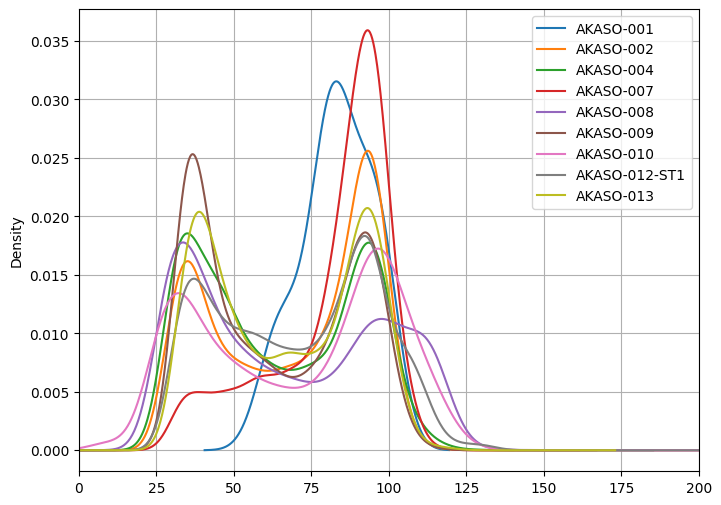

In [68]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df in wells_clean4:
    df.GR.plot(kind ='kde', ax=ax, label=label)
    plt.xlim(0, 200)
plt.grid(True)
plt.legend()
plt.savefig('before_normalisation.png', dpi=300)

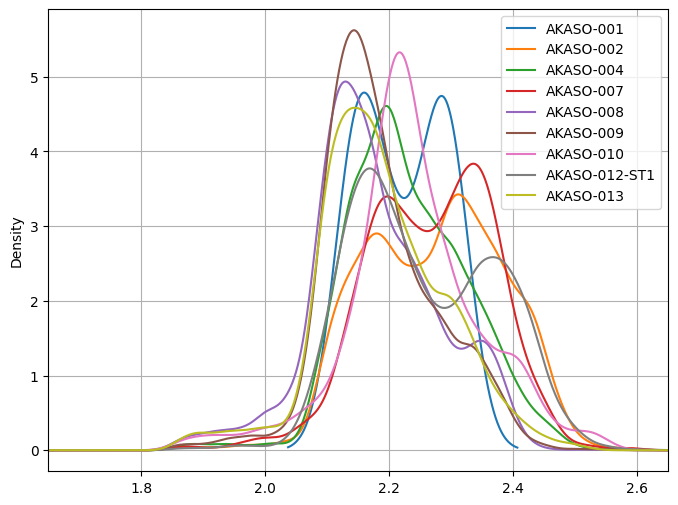

In [69]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df in wells_clean4:
    df.RHOB.plot(kind ='kde', ax=ax, label=label)
    plt.xlim(1.65, 2.65)
plt.grid(True)
plt.legend()
plt.savefig('before_normalisation.png', dpi=300)

The GR and RHOB logs has been normalised. there is no further normalisation

## Desplay Well Logs for Multi-Well

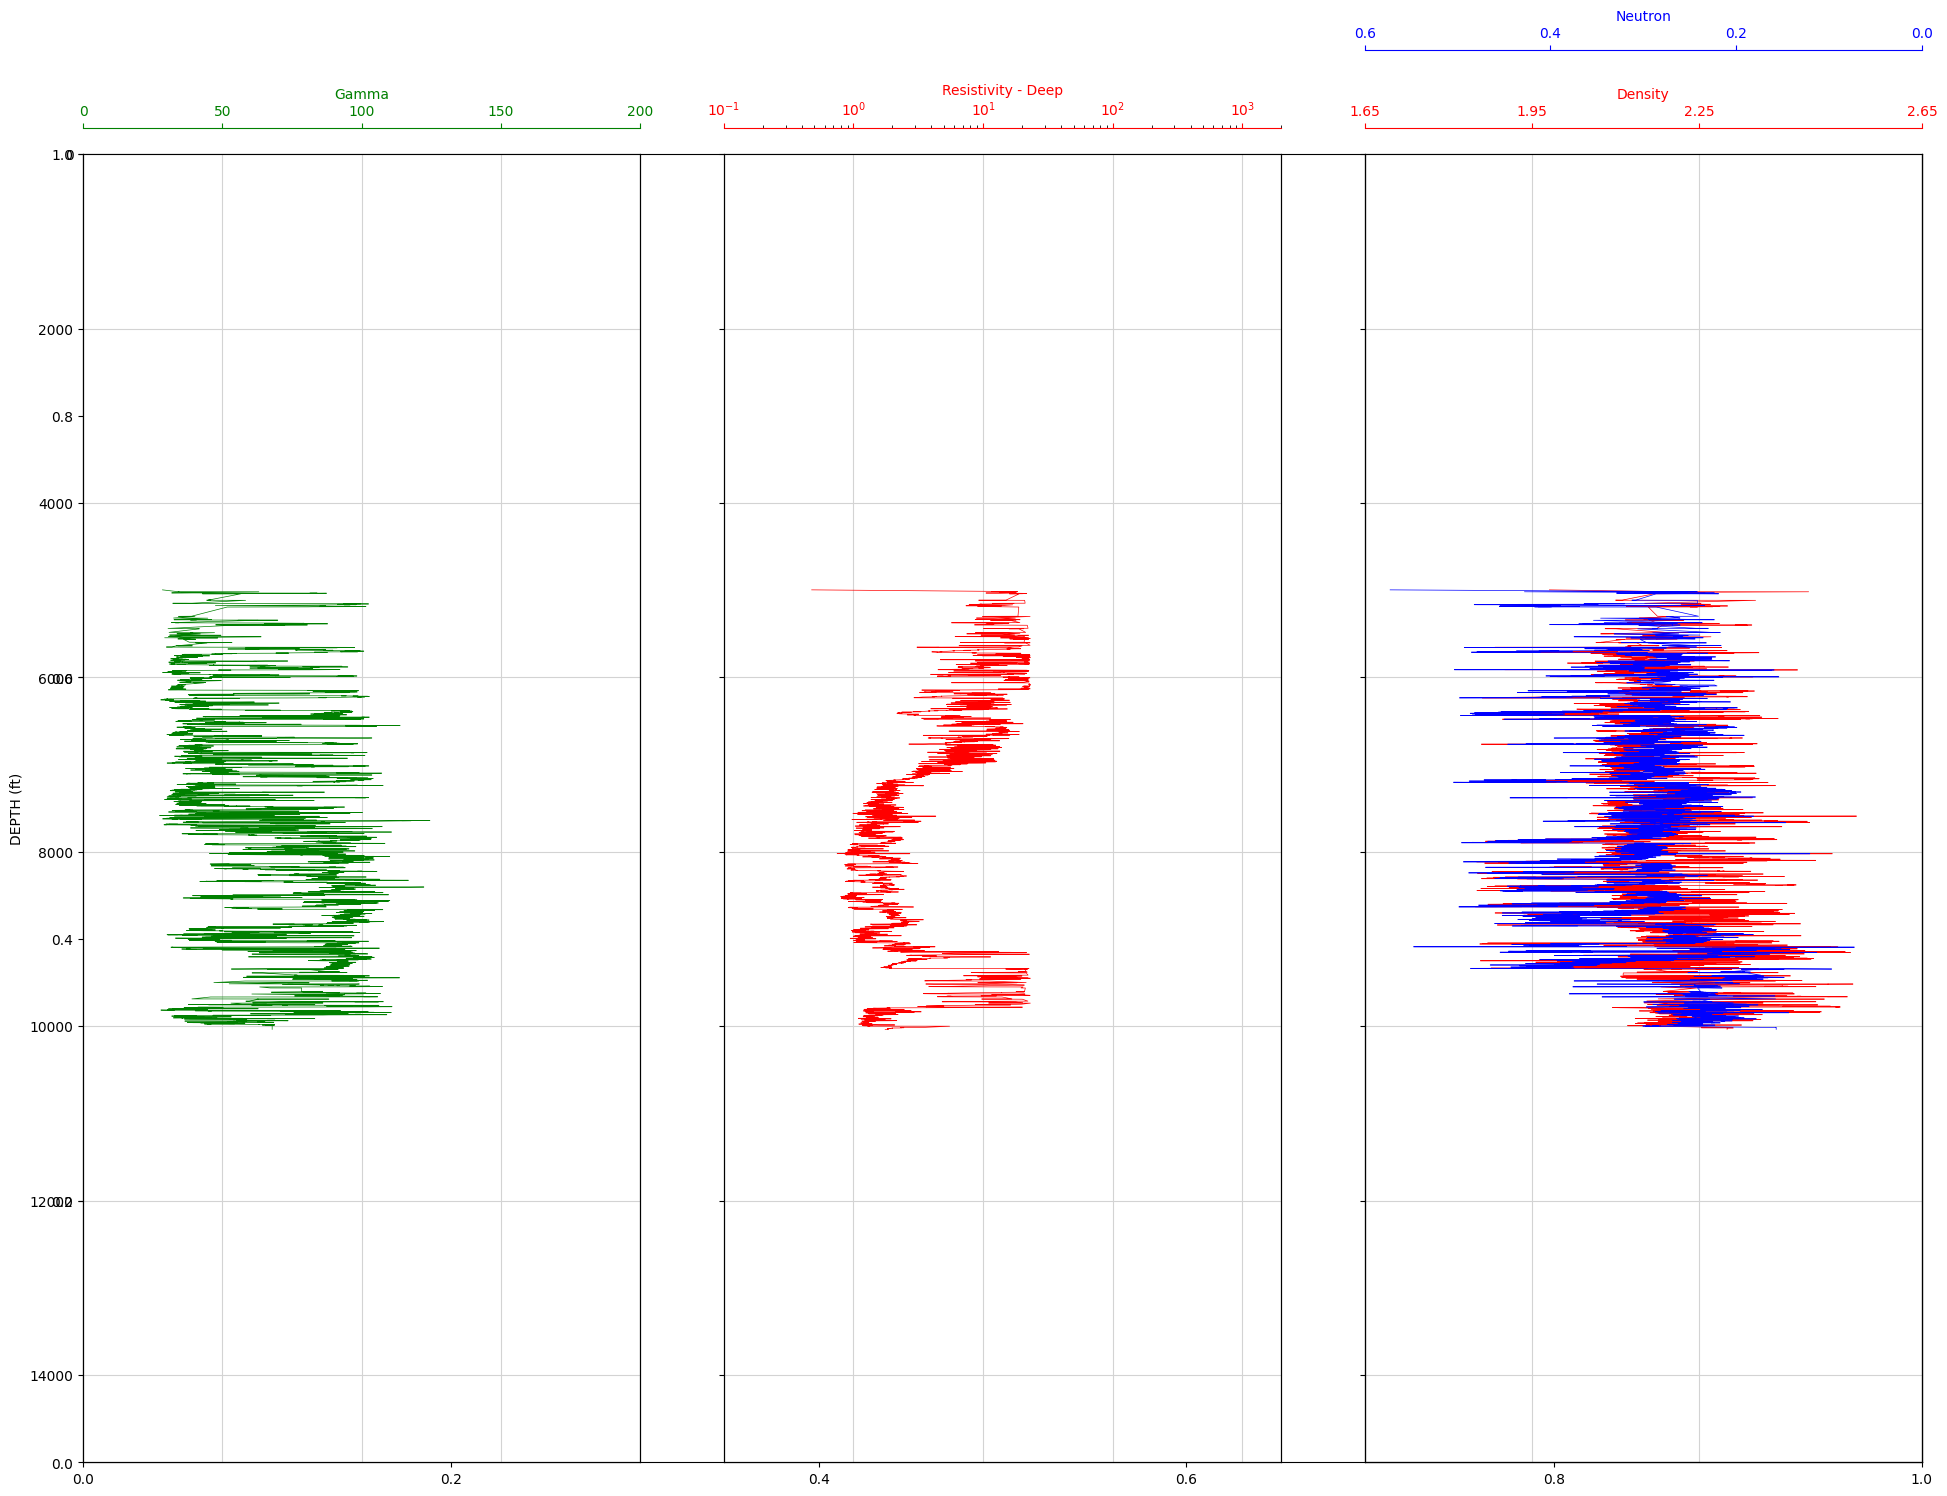

In [70]:
grouped = wells_clean3.groupby('WELL')

# Selecting one well out of the other wells
selected_well = 'AKASO-013'
well_data = grouped.get_group(selected_well)

fig, ax = plt.subplots(figsize=(20,15))

#Set up the plot axes
ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1, sharey = ax1)
ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1, sharey = ax1)
ax4 = ax3.twiny() #Twins the y-axis for the density track with the neutron track


# As our curve scales will be detached from the top of the track,
# this code adds the top border back in without dealing with splines
ax10 = ax1.twiny()
ax10.xaxis.set_visible(False)
ax11 = ax2.twiny()
ax11.xaxis.set_visible(False)
ax12 = ax3.twiny()
ax12.xaxis.set_visible(False)

# Gamma Ray track
ax1.plot(well_data["GR"], well_data['DEPTH'], color = "green", linewidth = 0.5)
ax1.set_xlabel("Gamma")
ax1.xaxis.label.set_color("green")
ax1.set_xlim(0, 200)
ax1.set_ylabel("DEPTH (ft)")
ax1.tick_params(axis='x', colors="green")
ax1.spines["top"].set_edgecolor("green")
ax1.title.set_color('green')
ax1.set_xticks([0, 50, 100, 150, 200])

# Resistivity track
ax2.plot(well_data["LLD"], well_data['DEPTH'], color = "red", linewidth = 0.5)
ax2.set_xlabel("Resistivity - Deep")
ax2.set_xlim(0.2, 2000)
ax2.xaxis.label.set_color("red")
ax2.tick_params(axis='x', colors="red")
ax2.spines["top"].set_edgecolor("red")
ax2.set_xticks([0.1, 1, 10, 100, 1000])
ax2.semilogx()

# Density track
ax3.plot(well_data["RHOB"], well_data['DEPTH'], color = "red", linewidth = 0.5)
ax3.set_xlabel("Density")
ax3.set_xlim(1.65, 2.65)
ax3.xaxis.label.set_color("red")
ax3.tick_params(axis='x', colors="red")
ax3.spines["top"].set_edgecolor("red")
ax3.set_xticks([1.65, 1.95, 2.25, 2.65])


# Neutron track placed ontop of density track
ax4.plot(well_data["NPHI"], well_data['DEPTH'], color = "blue", linewidth = 0.5)
ax4.set_xlabel('Neutron')
ax4.xaxis.label.set_color("blue")
ax4.set_xlim(0.6, 0)
ax4.set_ylim(15000, 0)
ax4.tick_params(axis='x', colors="blue")
ax4.spines["top"].set_position(("axes", 1.08))
ax4.spines["top"].set_visible(True)
ax4.spines["top"].set_edgecolor("blue")
ax4.set_xticks([0.6,  0.4, 0.2, 0])


# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2, ax3]:
    ax.set_ylim(15000, 0)
    ax.grid(which='major', color='lightgrey', linestyle='-')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.spines["top"].set_position(("axes", 1.02))
    
    
for ax in [ax2, ax3]:
    plt.setp(ax.get_yticklabels(), visible = False)
    
plt.tight_layout()
fig.subplots_adjust(wspace = 0.15)


In [71]:
#wells_clean3.to_csv('Petrophysics_Preprocessing.csv', index=False)